In [1]:
%load_ext autoreload
%autoreload 2
from rl4co.envs.routing import PDPTWEnv, PDPTWGenerator
from rl4co.models.zoo import AttentionModel
from ortools_solver import darp_solver
from rl4co.models import AttentionModelPolicy, REINFORCE
from rl4co.models.rl import PPO

In [3]:
import torch
from rl4co.models.zoo import AttentionModelPolicy
from rl4co.envs.routing import PDPTWEnv

env = PDPTWEnv()

# Load checkpoint

model_checkpoint = AttentionModel.load_from_checkpoint("checkpoints/sf_newenv_2/epoch_epoch=067.ckpt", strict=False, map_location='cpu', env=env)

/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.6, which is newer than your current Lightning version: v2.5.5
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['baseline.baseline.policy.encoder.init_embedding.project.weight', 'baseline.baseline.policy.encoder.init_e

In [4]:
# Initiate untrained policy
untrained_policy = AttentionModelPolicy(env_name=env.name,
                                        embed_dim = 128,
                                        num_encoder_layers=3,
                                        num_heads=8)

{'reward': tensor([-658.2167]), 'log_likelihood': tensor([-19.3217], grad_fn=<SumBackward1>), 'actions': tensor([[29, 30, 23, 24, 49, 50, 37, 38,  0,  9,  5, 19, 41,  6, 53, 10, 54, 20,
         42, 59, 21, 22, 60, 11, 25, 43, 44, 12, 26,  7, 15, 35,  3, 16,  8, 47,
         55,  4, 56, 48, 36,  0, 51, 45, 46, 39, 52, 40, 57, 58,  1,  2, 27, 33,
         31, 28, 17, 32, 18,  0, 13, 34, 14,  0]])}
{'reward': tensor([-974.7334]), 'log_likelihood': tensor([-60.7126], grad_fn=<SumBackward1>), 'actions': tensor([[29, 30,  9, 10, 21, 59, 22, 60,  3,  4, 47, 55, 48, 56, 37, 38,  0,  7,
         15, 31, 35,  8, 17, 36, 18,  0, 45, 23, 24, 46,  1,  2, 33, 13, 34, 16,
         32,  0, 19, 41, 20, 42, 43, 11, 44, 27, 28, 14,  0, 51, 53, 54, 52, 39,
         40, 49, 50, 25, 26, 12,  0,  5,  6, 57, 58,  0]])}


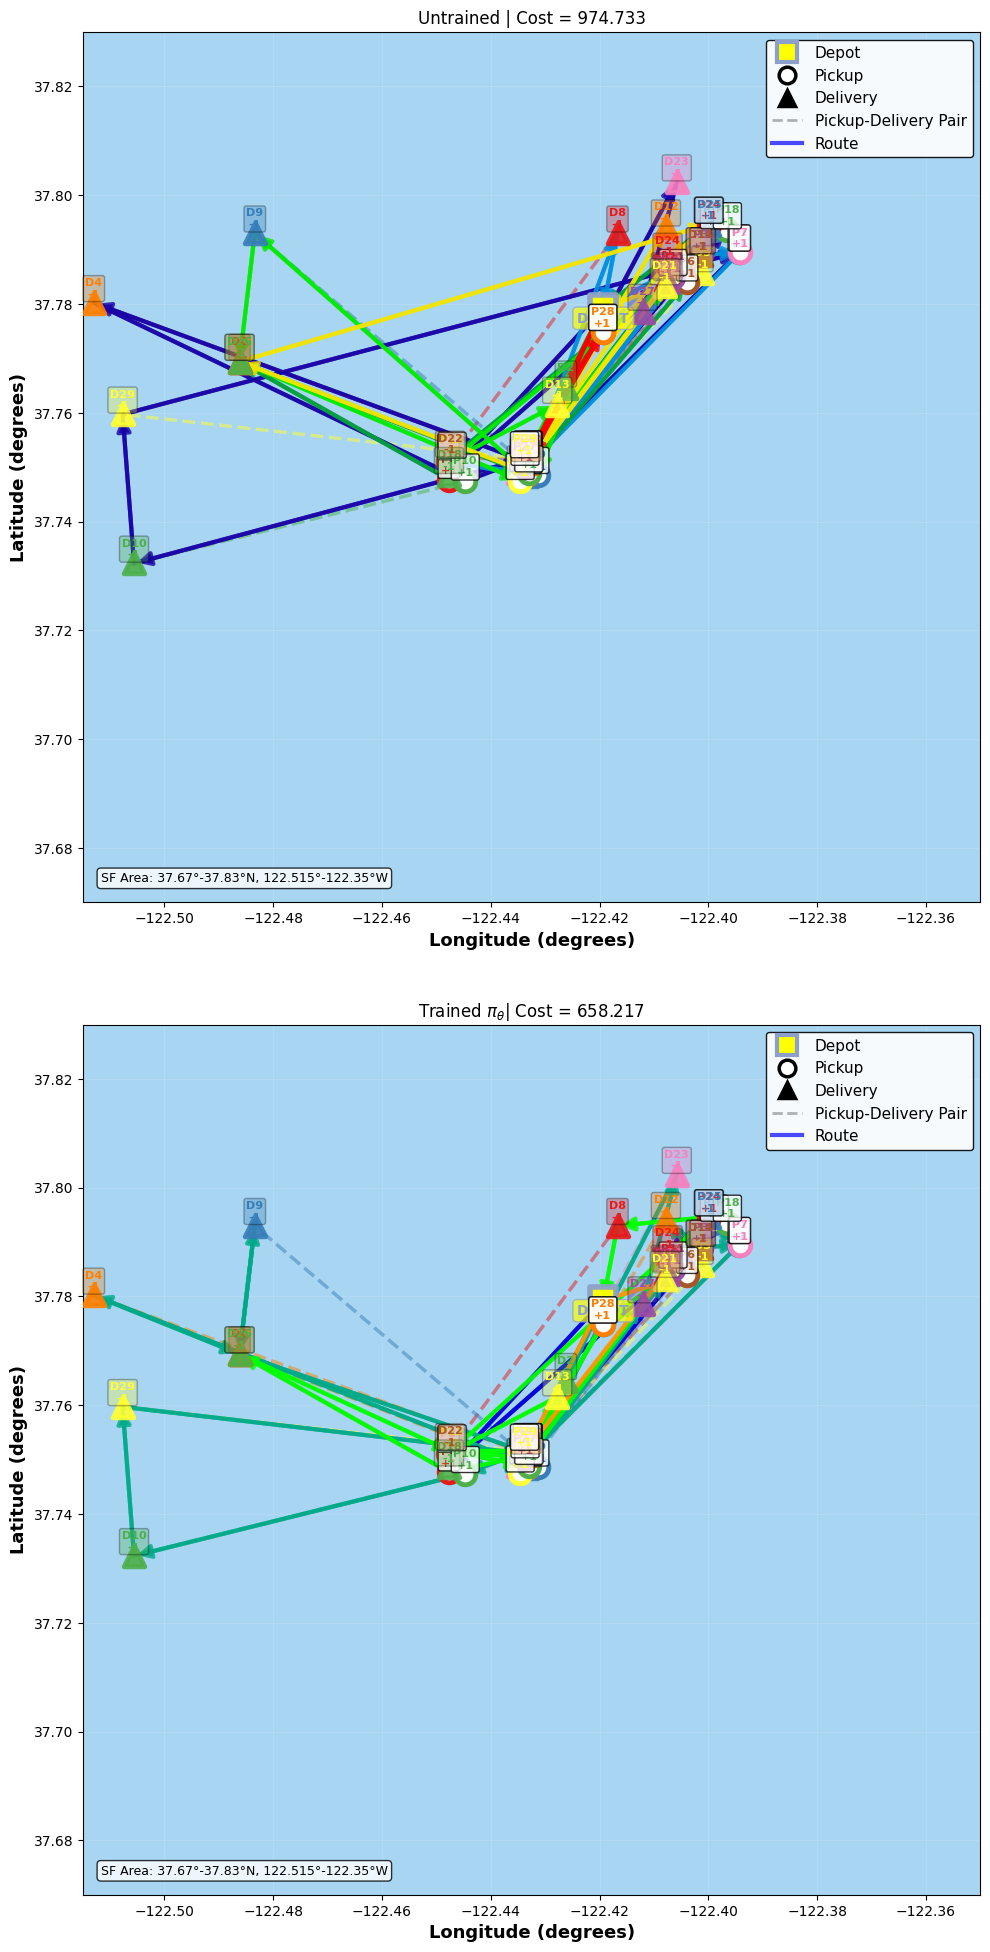

In [9]:
device = 'cpu'

td_init = PDPTWEnv(generator_params={"num_customers":30}).reset(batch_size=[1]).to(device)

trained_policy = model_checkpoint.policy.to(device)

trained_out = trained_policy(td_init.clone(), phase="test", decode_type="sampling", return_actions=True)
untrained_out = untrained_policy(td_init.clone(), phase="test", decode_type="sampling", return_actions=True)

actions_trained = trained_out['actions'].cpu().detach()
actions_untrained = untrained_out["actions"].cpu().detach()

rewards_trained = trained_out['reward']
rewards_untrained = untrained_out['reward']

import matplotlib.pyplot as plt
for i, td in enumerate(td_init):
    fig, axs = plt.subplots(2,1, figsize=(11,20))
    env.render(td, actions_untrained[i], ax=axs[0]) 
    env.render(td, actions_trained[i], ax=axs[1])
    axs[0].set_title(f"Untrained | Cost = {-rewards_untrained[i].item():.3f}")
    axs[1].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-rewards_trained[i].item():.3f}")

print(trained_out)
print(untrained_out)

In [ ]:
device = 'cpu'

td_init = PDPTWEnv(generator_params={"num_customers":30}).reset(batch_size=[1]).to(device)

trained_policy = model_checkpoint.policy.to(device)

trained_out = trained_policy(td_init.clone(), phase="test", decode_type="sampling", return_actions=True)
untrained_out = untrained_policy(td_init.clone(), phase="test", decode_type="sampling", return_actions=True)


In [ ]:
from tqdm import tqdm

records = {}

for i in tqdm(range(5, 6, 5)):
    or_tools = []
    neural = []

    for j in tqdm(range(60)):  # Each instance run for j times
        td_init = PDPTWEnv(generator_params={"num_customers": i}).reset(batch_size=[1]).to(device)

        neural_out = trained_policy(
            td_init.clone(),
            phase="test",
            decode_type="greedy",
            return_actions=True,
        )
        print(neural_out)
        or_out = darp_solver(td_init, time_limit_seconds=1)

        # be careful: neural_out["reward"] is probably a tensor → convert to scalar if needed
        neural.append((- neural_out["reward"] - neural_out["waiting_penalty"]).detach().cpu().item())
        or_tools.append(or_out["total_distance"])

    # create the entry for this i
    records[f"{i} req"] = {
        "or_tools": or_tools,
        "neural": neural,
    }

{'reward': tensor([-817.8667]),
 'log_likelihood': tensor([-16.5396], grad_fn=<SumBackward1>),
 'actions': tensor([[17, 27, 29,  5, 18, 28,  6,  9, 47,  3, 10, 48,  7,  8,  0, 11, 30, 12,
          57, 37, 58,  4,  0, 31, 49, 32,  1, 41,  2, 42, 23, 43, 24, 45, 19, 20,
          46, 39, 53, 40, 51, 54, 25, 52, 26, 59, 55, 60, 56,  0, 21, 22, 13, 35,
          15, 36, 16, 33, 34,  0, 38, 50, 14,  0, 44,  0]])}

In [11]:
from tqdm import tqdm

records = {}

for i in tqdm(range(5, 31, 5)):
    or_tools = []
    neural = []

    for j in tqdm(range(60)):  # Each instance run for j times
        td_init = PDPTWEnv(generator_params={"num_customers": i}).reset(batch_size=[1]).to(device)

        neural_out = trained_policy(
            td_init.clone(),
            phase="test",
            decode_type="greedy",
            return_actions=True,
        )
        print(neural_out)
        or_out = darp_solver(td_init, time_limit_seconds=1)

        # be careful: neural_out["reward"] is probably a tensor → convert to scalar if needed
        neural.append((neural_out["reward"]).detach().cpu().item())
        or_tools.append(or_out["total_time"])

    # create the entry for this i
    records[f"{i} req"] = {
        "or_tools": or_tools,
        "neural": neural,
    }
"""
import json
with open("record.json", "w") as f:
    json.dump(records, f, indent=4)"""

  0%|          | 0/6 [00:00<?, ?it/s]

{'reward': tensor([-173.1333]), 'log_likelihood': tensor([-0.2583], grad_fn=<SumBackward1>), 'actions': tensor([[ 5,  6,  3,  7,  8,  1,  9,  2, 10,  0,  4,  0]])}


{'reward': tensor([-173.6000]), 'log_likelihood': tensor([-0.1931], grad_fn=<SumBackward1>), 'actions': tensor([[ 1,  5,  2,  6,  3,  4,  7,  9,  8, 10,  0]])}


{'reward': tensor([-131.8500]), 'log_likelihood': tensor([-0.1107], grad_fn=<SumBackward1>), 'actions': tensor([[ 3,  9,  4,  1,  2,  7,  8,  0,  5,  6, 10,  0]])}


{'reward': tensor([-130.1500]), 'log_likelihood': tensor([-0.0275], grad_fn=<SumBackward1>), 'actions': tensor([[ 1,  2,  3,  4,  5,  6,  0,  7,  9,  8, 10,  0]])}


{'reward': tensor([-218.1667]), 'log_likelihood': tensor([-0.0004], grad_fn=<SumBackward1>), 'actions': tensor([[ 1,  7,  2,  8,  3,  4,  5,  6,  9, 10,  0]])}


{'reward': tensor([-205.4833]), 'log_likelihood': tensor([-4.7684e-07], grad_fn=<SumBackward1>), 'actions': tensor([[ 1,  2,  9, 10,  0,  5,  6,  7,  8,  3,  4,  0]])}


{'reward': tensor([-177.2500]), 'log_likelihood': tensor([-0.0002], grad_fn=<SumBackward1>), 'actions': tensor([[ 3,  4,  7,  8,  5,  6,  0,  9,  1, 10,  2,  0]])}


{'reward': tensor([-155.1833]), 'log_likelihood': tensor([-0.1936], grad_fn=<SumBackward1>), 'actions': tensor([[ 5,  6,  7,  1,  3,  8,  4,  2,  9, 10,  0]])}


{'reward': tensor([-157.3500]), 'log_likelihood': tensor([-0.5669], grad_fn=<SumBackward1>), 'actions': tensor([[ 7,  8,  5,  1,  9,  2,  6, 10,  3,  4,  0]])}


{'reward': tensor([-192.1000]), 'log_likelihood': tensor([-0.0013], grad_fn=<SumBackward1>), 'actions': tensor([[ 5,  6,  7,  3,  8,  4,  9, 10,  1,  2,  0]])}


{'reward': tensor([-168.6333]), 'log_likelihood': tensor([-0.0005], grad_fn=<SumBackward1>), 'actions': tensor([[ 3,  9,  4, 10,  1,  2,  5,  7,  6,  8,  0]])}


{'reward': tensor([-164.1333]), 'log_likelihood': tensor([-0.0666], grad_fn=<SumBackward1>), 'actions': tensor([[ 5,  3,  6,  4,  7,  8,  1,  2,  9, 10,  0]])}


{'reward': tensor([-198.7167]), 'log_likelihood': tensor([-0.1995], grad_fn=<SumBackward1>), 'actions': tensor([[ 3,  4,  9,  7, 10,  8,  5,  6,  1,  2,  0]])}


{'reward': tensor([-170.5000]), 'log_likelihood': tensor([-0.0651], grad_fn=<SumBackward1>), 'actions': tensor([[ 7,  1,  3,  8,  4,  5,  6,  9, 10,  0,  2,  0]])}


{'reward': tensor([-173.3333]), 'log_likelihood': tensor([-0.0003], grad_fn=<SumBackward1>), 'actions': tensor([[ 5,  3,  6,  4,  1,  2,  0,  7,  8,  9, 10,  0]])}


{'reward': tensor([-168.9000]), 'log_likelihood': tensor([-0.0017], grad_fn=<SumBackward1>), 'actions': tensor([[ 5,  6,  1,  2,  0,  7,  8,  9,  3, 10,  4,  0]])}


{'reward': tensor([-154.1333]), 'log_likelihood': tensor([-0.0014], grad_fn=<SumBackward1>), 'actions': tensor([[ 3,  9,  5,  4, 10,  6,  1,  2,  7,  8,  0]])}


{'reward': tensor([-180.4667]), 'log_likelihood': tensor([-2.3842e-06], grad_fn=<SumBackward1>), 'actions': tensor([[ 9, 10,  5,  6,  1,  2,  7,  8,  3,  4,  0]])}


{'reward': tensor([-142.3333]), 'log_likelihood': tensor([-0.0049], grad_fn=<SumBackward1>), 'actions': tensor([[ 3,  9,  4, 10,  5,  6,  1,  7,  2,  8,  0]])}


{'reward': tensor([-157.5167]), 'log_likelihood': tensor([-0.0008], grad_fn=<SumBackward1>), 'actions': tensor([[ 9, 10,  7,  8,  3,  1,  4,  2,  5,  6,  0]])}


{'reward': tensor([-150.2167]), 'log_likelihood': tensor([-4.3153e-05], grad_fn=<SumBackward1>), 'actions': tensor([[ 1,  2,  9,  7, 10,  8,  5,  6,  3,  4,  0]])}


{'reward': tensor([-132.2000]), 'log_likelihood': tensor([-0.4407], grad_fn=<SumBackward1>), 'actions': tensor([[ 9,  5, 10,  6,  7,  1,  2,  8,  3,  4,  0]])}


{'reward': tensor([-186.3000]), 'log_likelihood': tensor([-0.0264], grad_fn=<SumBackward1>), 'actions': tensor([[ 7,  8,  9, 10,  3,  4,  0,  1,  5,  2,  6,  0]])}


{'reward': tensor([-151.0167]), 'log_likelihood': tensor([-8.3325e-05], grad_fn=<SumBackward1>), 'actions': tensor([[ 3,  4,  9,  5,  7,  6,  8,  1,  2,  0, 10,  0]])}


{'reward': tensor([-174.9167]), 'log_likelihood': tensor([-0.0134], grad_fn=<SumBackward1>), 'actions': tensor([[ 1,  5,  2,  6,  7,  8,  3,  9,  4, 10,  0]])}


{'reward': tensor([-146.7667]), 'log_likelihood': tensor([-0.4682], grad_fn=<SumBackward1>), 'actions': tensor([[ 9,  7, 10,  8,  1,  5,  6,  2,  3,  4,  0]])}


{'reward': tensor([-174.6333]), 'log_likelihood': tensor([-0.1323], grad_fn=<SumBackward1>), 'actions': tensor([[ 9,  3,  5, 10,  4,  6,  7,  8,  0,  1,  2,  0]])}


{'reward': tensor([-131.2667]), 'log_likelihood': tensor([-0.0025], grad_fn=<SumBackward1>), 'actions': tensor([[ 1,  2,  5,  6,  9,  3,  4, 10,  0,  7,  8,  0]])}


{'reward': tensor([-124.2500]), 'log_likelihood': tensor([-0.6116], grad_fn=<SumBackward1>), 'actions': tensor([[ 7,  8,  9, 10,  3,  4,  5,  6,  1,  2,  0]])}


{'reward': tensor([-130.7833]), 'log_likelihood': tensor([-1.2517e-05], grad_fn=<SumBackward1>), 'actions': tensor([[ 7,  9,  8, 10,  5,  6,  3,  4,  0,  1,  2,  0]])}


{'reward': tensor([-221.9667]), 'log_likelihood': tensor([-8.3446e-06], grad_fn=<SumBackward1>), 'actions': tensor([[ 5,  6,  9, 10,  7,  8,  0,  3,  4,  1,  2,  0]])}


{'reward': tensor([-191.5000]), 'log_likelihood': tensor([-0.0035], grad_fn=<SumBackward1>), 'actions': tensor([[ 9,  3, 10,  5,  6,  0,  4,  7,  8,  1,  2,  0]])}


{'reward': tensor([-146.0500]), 'log_likelihood': tensor([-0.0315], grad_fn=<SumBackward1>), 'actions': tensor([[ 3,  5,  4,  6,  1,  2,  9,  7,  8, 10,  0]])}


{'reward': tensor([-154.4333]), 'log_likelihood': tensor([-0.0001], grad_fn=<SumBackward1>), 'actions': tensor([[ 3,  4,  9, 10,  5,  6,  1,  2,  0,  7,  8,  0]])}


{'reward': tensor([-130.9667]), 'log_likelihood': tensor([-0.4784], grad_fn=<SumBackward1>), 'actions': tensor([[ 7,  8,  1,  2,  0,  3,  9,  5,  4,  6, 10,  0]])}


{'reward': tensor([-200.6167]), 'log_likelihood': tensor([-0.0002], grad_fn=<SumBackward1>), 'actions': tensor([[ 5,  6,  7,  8,  0,  9, 10,  1,  3,  2,  4,  0]])}


{'reward': tensor([-186.6833]), 'log_likelihood': tensor([-0.0080], grad_fn=<SumBackward1>), 'actions': tensor([[ 1,  2,  5,  6,  0,  3,  7,  4,  8,  9, 10,  0]])}


{'reward': tensor([-181.0500]), 'log_likelihood': tensor([-0.3872], grad_fn=<SumBackward1>), 'actions': tensor([[ 7,  8,  3,  4,  5,  1,  6,  2,  0,  9, 10,  0]])}


{'reward': tensor([-164.7667]), 'log_likelihood': tensor([-0.6094], grad_fn=<SumBackward1>), 'actions': tensor([[ 1,  9,  2, 10,  3,  5,  4,  6,  7,  8,  0]])}


{'reward': tensor([-136.5667]), 'log_likelihood': tensor([-0.7924], grad_fn=<SumBackward1>), 'actions': tensor([[ 5,  3,  6,  4,  7,  8,  9, 10,  0,  1,  2,  0]])}


{'reward': tensor([-182.1833]), 'log_likelihood': tensor([-0.5057], grad_fn=<SumBackward1>), 'actions': tensor([[ 7,  8,  5,  6,  1,  3,  2,  4,  0,  9, 10,  0]])}


{'reward': tensor([-226.5000]), 'log_likelihood': tensor([-3.5763e-07], grad_fn=<SumBackward1>), 'actions': tensor([[ 1,  2,  9, 10,  0,  5,  6,  7,  8,  3,  4,  0]])}


{'reward': tensor([-192.5000]), 'log_likelihood': tensor([-0.0009], grad_fn=<SumBackward1>), 'actions': tensor([[ 3,  4,  9,  5, 10,  6,  7,  8,  1,  2,  0]])}


{'reward': tensor([-166.7333]), 'log_likelihood': tensor([-2.3007e-05], grad_fn=<SumBackward1>), 'actions': tensor([[ 7,  5,  8,  6,  1,  2,  9, 10,  3,  4,  0]])}


{'reward': tensor([-190.2500]), 'log_likelihood': tensor([-0.0002], grad_fn=<SumBackward1>), 'actions': tensor([[ 9, 10,  5,  6,  7,  8,  0,  3,  4,  1,  2,  0]])}


{'reward': tensor([-149.4667]), 'log_likelihood': tensor([-3.5763e-06], grad_fn=<SumBackward1>), 'actions': tensor([[ 5,  6,  9, 10,  7,  8,  1,  2,  0,  3,  4,  0]])}


{'reward': tensor([-130.4167]), 'log_likelihood': tensor([-0.4022], grad_fn=<SumBackward1>), 'actions': tensor([[ 5,  6,  3,  4,  7,  8,  1,  9, 10,  2,  0]])}


{'reward': tensor([-118.9167]), 'log_likelihood': tensor([-0.6911], grad_fn=<SumBackward1>), 'actions': tensor([[ 9,  5,  3,  6, 10,  4,  1,  2,  7,  8,  0]])}


{'reward': tensor([-188.8667]), 'log_likelihood': tensor([-0.5746], grad_fn=<SumBackward1>), 'actions': tensor([[ 9,  1, 10,  2,  3,  4,  7,  8,  5,  6,  0]])}


{'reward': tensor([-174.5500]), 'log_likelihood': tensor([-0.2477], grad_fn=<SumBackward1>), 'actions': tensor([[ 9,  3, 10,  4,  5,  6,  1,  2,  7,  8,  0]])}


{'reward': tensor([-217.9000]), 'log_likelihood': tensor([-8.9407e-06], grad_fn=<SumBackward1>), 'actions': tensor([[ 7,  8,  5,  6,  3,  4,  1,  2,  9, 10,  0]])}


{'reward': tensor([-158.6667]), 'log_likelihood': tensor([-2.9802e-06], grad_fn=<SumBackward1>), 'actions': tensor([[ 7,  8,  5,  6,  1,  2,  3,  4,  0,  9, 10,  0]])}


{'reward': tensor([-132.1000]), 'log_likelihood': tensor([-1.0848e-05], grad_fn=<SumBackward1>), 'actions': tensor([[ 5,  6,  7,  1,  8,  2,  3,  9,  4, 10,  0]])}


{'reward': tensor([-156.5167]), 'log_likelihood': tensor([-0.6940], grad_fn=<SumBackward1>), 'actions': tensor([[ 5,  7,  8,  6,  3,  4,  0,  9, 10,  1,  2,  0]])}


{'reward': tensor([-157.8833]), 'log_likelihood': tensor([-0.4617], grad_fn=<SumBackward1>), 'actions': tensor([[ 1,  9,  2, 10,  5,  3,  6,  4,  0,  7,  8,  0]])}


{'reward': tensor([-178.0833]), 'log_likelihood': tensor([-0.0002], grad_fn=<SumBackward1>), 'actions': tensor([[ 1,  2,  5,  9,  6, 10,  7,  8,  0,  3,  4,  0]])}


{'reward': tensor([-121.2333]), 'log_likelihood': tensor([-0.7165], grad_fn=<SumBackward1>), 'actions': tensor([[ 5,  7,  8,  6,  3,  4,  1,  9,  2, 10,  0]])}


{'reward': tensor([-127.6000]), 'log_likelihood': tensor([-0.7100], grad_fn=<SumBackward1>), 'actions': tensor([[ 9,  3,  7,  4, 10,  8,  1,  2,  5,  6,  0]])}


{'reward': tensor([-160.9333]), 'log_likelihood': tensor([-0.8663], grad_fn=<SumBackward1>), 'actions': tensor([[ 5,  9, 10,  6,  3,  7,  4,  8,  0,  1,  2,  0]])}


{'reward': tensor([-149.4333]), 'log_likelihood': tensor([-3.6597e-05], grad_fn=<SumBackward1>), 'actions': tensor([[ 9, 10,  7,  8,  3,  4,  5,  6,  1,  2,  0]])}


 17%|█▋        | 1/6 [01:08<05:40, 68.15s/it]

{'reward': tensor([-221.8000]), 'log_likelihood': tensor([-2.6664], grad_fn=<SumBackward1>), 'actions': tensor([[ 3, 11,  7,  9,  4,  8, 13, 19, 14, 20,  5, 15,  6, 16,  0, 12, 10, 17,
         18,  1,  2,  0]])}


{'reward': tensor([-296.7000]), 'log_likelihood': tensor([-0.4200], grad_fn=<SumBackward1>), 'actions': tensor([[ 7,  8, 17,  3, 15,  5, 18, 16,  9, 10, 19, 20,  0,  1,  6,  2, 13, 14,
          0,  4, 11, 12,  0]])}


{'reward': tensor([-258.6833]), 'log_likelihood': tensor([-1.9144], grad_fn=<SumBackward1>), 'actions': tensor([[11, 12, 15, 13,  3,  9, 16,  4, 14, 19, 20, 17,  5, 18,  6,  1,  7,  2,
          8,  0, 10,  0]])}


{'reward': tensor([-312.1166]), 'log_likelihood': tensor([-1.3109], grad_fn=<SumBackward1>), 'actions': tensor([[11,  1,  2, 12, 15, 16,  5,  6,  0,  7,  9, 10,  8,  3,  4, 13, 14, 17,
         19, 18, 20,  0]])}


{'reward': tensor([-341.1500]), 'log_likelihood': tensor([-0.6229], grad_fn=<SumBackward1>), 'actions': tensor([[11, 12,  1,  2,  3, 13,  4, 14,  9, 10, 17,  7, 19, 18,  8, 20,  5,  6,
          0, 15, 16,  0]])}


{'reward': tensor([-328.3834]), 'log_likelihood': tensor([-0.5885], grad_fn=<SumBackward1>), 'actions': tensor([[ 3, 17,  4, 18,  1,  2, 13, 14,  9, 10,  0, 15, 16, 19, 20,  0, 11,  7,
          5,  8, 12,  6,  0]])}


{'reward': tensor([-289.1667]), 'log_likelihood': tensor([-6.4968e-05], grad_fn=<SumBackward1>), 'actions': tensor([[11, 19, 12, 20, 13, 14,  1,  2,  5,  6,  0,  3,  4, 15, 16,  9, 10,  7,
          8,  0, 17, 18,  0]])}


{'reward': tensor([-309.6167]), 'log_likelihood': tensor([-0.0248], grad_fn=<SumBackward1>), 'actions': tensor([[11, 13,  1, 14, 12,  9,  2,  3, 10,  5,  6, 17, 18,  0,  4, 15, 16, 19,
         20,  7,  8,  0]])}


{'reward': tensor([-284.7000]), 'log_likelihood': tensor([-0.4010], grad_fn=<SumBackward1>), 'actions': tensor([[ 7, 13,  8, 14, 19, 17, 15, 20, 18, 16,  5,  1,  6,  2,  9, 11, 10, 12,
          0,  3,  4,  0]])}


{'reward': tensor([-297.2833]), 'log_likelihood': tensor([-0.2400], grad_fn=<SumBackward1>), 'actions': tensor([[11, 12,  3,  4,  0, 13, 15, 14,  9, 10,  7,  8, 17, 18, 19,  1,  5, 20,
          2,  6,  0, 16,  0]])}


{'reward': tensor([-263.2500]), 'log_likelihood': tensor([-3.1534], grad_fn=<SumBackward1>), 'actions': tensor([[17,  3, 19, 11, 12,  4, 18, 13, 14,  5,  7,  8, 15, 16,  0,  1,  9, 20,
          2, 10,  6,  0]])}


{'reward': tensor([-282.2167]), 'log_likelihood': tensor([-0.2112], grad_fn=<SumBackward1>), 'actions': tensor([[11, 12,  1,  2,  0, 19, 13, 20, 14,  7,  8, 15,  9,  5, 16,  6, 17,  3,
         18,  4,  0, 10,  0]])}


{'reward': tensor([-266.0333]), 'log_likelihood': tensor([-0.4225], grad_fn=<SumBackward1>), 'actions': tensor([[ 3,  4, 11,  9, 12, 10,  7, 13,  8, 14,  5,  6,  0, 17, 18,  1, 15,  2,
         16,  0, 19, 20,  0]])}


{'reward': tensor([-284.6833]), 'log_likelihood': tensor([-1.5306], grad_fn=<SumBackward1>), 'actions': tensor([[ 9,  1, 10,  2, 11, 12, 13, 14,  3,  5, 17,  4,  6, 18,  0, 19, 20,  7,
          8, 15, 16,  0]])}


{'reward': tensor([-250.5000]), 'log_likelihood': tensor([-0.6055], grad_fn=<SumBackward1>), 'actions': tensor([[ 7,  9,  8, 10, 13, 14, 15,  5, 16,  6, 19,  1, 20,  2,  0, 11,  3, 12,
          4, 17, 18,  0]])}


{'reward': tensor([-282.3167]), 'log_likelihood': tensor([-1.0291], grad_fn=<SumBackward1>), 'actions': tensor([[17, 15, 16, 18,  9,  5, 10, 19, 11, 20,  7,  8, 13, 14,  0,  6, 12,  1,
          3,  2,  4,  0]])}


{'reward': tensor([-303.1167]), 'log_likelihood': tensor([-0.3920], grad_fn=<SumBackward1>), 'actions': tensor([[11, 12,  9,  7,  3, 10,  8,  5,  6, 19, 20, 15, 16, 13, 14,  0, 17,  4,
         18,  1,  2,  0]])}


{'reward': tensor([-256.4833]), 'log_likelihood': tensor([-0.6017], grad_fn=<SumBackward1>), 'actions': tensor([[13, 14,  3, 11,  4, 12, 15, 19,  5, 16, 20,  6,  7,  1,  9,  8,  2, 10,
          0, 17, 18,  0]])}


{'reward': tensor([-256.1667]), 'log_likelihood': tensor([-0.6996], grad_fn=<SumBackward1>), 'actions': tensor([[ 1,  2, 13, 14,  9, 10,  0, 11, 12,  5,  7,  6,  8, 19, 20, 17,  3,  4,
         15, 18, 16,  0]])}


{'reward': tensor([-324.8000]), 'log_likelihood': tensor([-0.3508], grad_fn=<SumBackward1>), 'actions': tensor([[17,  5, 19, 18, 13, 14, 15,  9, 16, 11, 10, 12,  7,  8,  0,  6,  3,  4,
          1,  2,  0, 20,  0]])}


{'reward': tensor([-257.8833]), 'log_likelihood': tensor([-0.6284], grad_fn=<SumBackward1>), 'actions': tensor([[19, 20,  7,  8, 13,  1, 14, 11, 12, 15, 16,  0, 17,  2, 18,  9, 10,  0,
          5,  6,  3,  4,  0]])}


{'reward': tensor([-274.1833]), 'log_likelihood': tensor([-1.1510], grad_fn=<SumBackward1>), 'actions': tensor([[15,  5, 16,  6,  7,  8,  0, 13, 19, 17, 20,  9, 14, 18, 10,  1,  2,  0,
         11,  3, 12,  4,  0]])}


{'reward': tensor([-295.7667]), 'log_likelihood': tensor([-0.3951], grad_fn=<SumBackward1>), 'actions': tensor([[11, 12,  3,  4,  0,  1, 19, 17, 18,  2,  5, 13,  6, 14,  7, 15,  8, 16,
          0, 20,  9, 10,  0]])}


{'reward': tensor([-341.2000]), 'log_likelihood': tensor([-0.7716], grad_fn=<SumBackward1>), 'actions': tensor([[13, 14,  7,  1, 11, 19, 12, 20, 15, 16, 17, 18,  9, 10,  3,  4,  0,  2,
          8,  5,  6,  0]])}


{'reward': tensor([-254.4000]), 'log_likelihood': tensor([-0.4858], grad_fn=<SumBackward1>), 'actions': tensor([[15, 16,  9,  5, 13, 10,  6, 14,  7,  1,  8,  2, 19, 17, 20, 18,  3,  4,
         11, 12,  0]])}


{'reward': tensor([-297.9333]), 'log_likelihood': tensor([-0.1162], grad_fn=<SumBackward1>), 'actions': tensor([[19,  1, 20, 11, 12, 15, 16,  3,  4,  0,  2,  9, 10, 13, 17, 14, 18,  5,
          7,  6,  8,  0]])}


{'reward': tensor([-308.0167]), 'log_likelihood': tensor([-0.0029], grad_fn=<SumBackward1>), 'actions': tensor([[13,  7, 14,  8, 19,  5, 20, 11, 12,  0,  9, 17, 10,  3,  1,  4,  6,  0,
         18,  2, 15, 16,  0]])}


{'reward': tensor([-260.6166]), 'log_likelihood': tensor([-0.7022], grad_fn=<SumBackward1>), 'actions': tensor([[ 1,  2, 15, 16,  3,  4,  0, 19, 20,  7,  8, 13,  9, 14, 10, 17, 18,  0,
         11,  5, 12,  6,  0]])}


{'reward': tensor([-246.8500]), 'log_likelihood': tensor([-0.4296], grad_fn=<SumBackward1>), 'actions': tensor([[ 3, 19,  7,  4,  8, 15, 16,  1,  2,  0, 17, 18,  5, 13,  6, 14,  9, 11,
         12, 10,  0, 20,  0]])}


{'reward': tensor([-271.7833]), 'log_likelihood': tensor([-0.1118], grad_fn=<SumBackward1>), 'actions': tensor([[15, 16, 19,  5,  9, 20, 10,  1, 17,  2,  3, 11, 12,  4,  0,  7,  6,  8,
         18, 13, 14,  0]])}


{'reward': tensor([-239.0667]), 'log_likelihood': tensor([-0.3888], grad_fn=<SumBackward1>), 'actions': tensor([[ 1, 15,  7, 16,  2,  8,  9, 13,  5, 10, 17, 14, 18,  0,  3, 19,  4, 20,
         11, 12,  6,  0]])}


{'reward': tensor([-274.8500]), 'log_likelihood': tensor([-0.6503], grad_fn=<SumBackward1>), 'actions': tensor([[ 9,  1, 10, 13, 14, 19, 20,  3,  4, 11, 17,  5, 12,  6,  0,  2, 15,  7,
         16,  8, 18,  0]])}


{'reward': tensor([-254.8000]), 'log_likelihood': tensor([-0.8030], grad_fn=<SumBackward1>), 'actions': tensor([[ 9, 15,  1, 10,  2, 16,  5,  6, 17, 18, 13, 19, 11, 14, 20,  3,  7,  4,
          8,  0, 12,  0]])}


{'reward': tensor([-267.0500]), 'log_likelihood': tensor([-0.8602], grad_fn=<SumBackward1>), 'actions': tensor([[11, 12, 15, 13,  9, 16,  7,  1,  8,  2,  3,  4, 17, 18, 19,  5, 20,  6,
          0, 14,  0, 10,  0]])}


{'reward': tensor([-214.4667]), 'log_likelihood': tensor([-1.5151], grad_fn=<SumBackward1>), 'actions': tensor([[17, 18,  7,  1, 13,  3,  8,  5,  4,  9, 10, 11, 12, 19, 20, 15, 16,  0,
          2, 14,  6,  0]])}


{'reward': tensor([-290.7667]), 'log_likelihood': tensor([-1.3968], grad_fn=<SumBackward1>), 'actions': tensor([[17,  3, 18,  4, 13, 19, 14, 11, 12,  9,  5, 15, 10,  7, 16,  8,  0,  1,
          2, 20,  6,  0]])}


{'reward': tensor([-272.6500]), 'log_likelihood': tensor([-0.3312], grad_fn=<SumBackward1>), 'actions': tensor([[17, 15,  3, 18, 16,  4,  1,  2,  0, 19,  9, 20,  5,  7,  6,  8, 11, 12,
         13, 14,  0, 10,  0]])}


{'reward': tensor([-326.9167]), 'log_likelihood': tensor([-1.8951], grad_fn=<SumBackward1>), 'actions': tensor([[13, 14,  5,  9, 11, 10,  6, 17, 19, 18,  1, 20,  2,  0,  7,  3,  4,  8,
         12,  0, 15, 16,  0]])}


{'reward': tensor([-261.2667]), 'log_likelihood': tensor([-0.3957], grad_fn=<SumBackward1>), 'actions': tensor([[ 1,  2, 19, 20,  9,  7, 10,  8,  0, 15,  3, 13, 17,  4, 16, 14,  5, 18,
         11, 12,  6,  0]])}


{'reward': tensor([-249.1500]), 'log_likelihood': tensor([-1.2354], grad_fn=<SumBackward1>), 'actions': tensor([[ 7, 13,  8,  3, 15,  4,  9, 16,  5, 10,  6,  0, 14, 11, 12, 17, 18,  0,
          1, 19, 20,  2,  0]])}


{'reward': tensor([-296.0667]), 'log_likelihood': tensor([-0.1161], grad_fn=<SumBackward1>), 'actions': tensor([[ 7,  8, 15, 13, 16,  3,  4,  1,  9,  2, 11, 10, 12,  5,  6,  0, 14, 19,
         20, 17, 18,  0]])}


{'reward': tensor([-263.2667]), 'log_likelihood': tensor([-0.3238], grad_fn=<SumBackward1>), 'actions': tensor([[13, 14,  5, 15,  6, 16, 11, 12,  9,  7, 10,  8,  0,  1,  2, 17, 19, 18,
         20,  3,  4,  0]])}


{'reward': tensor([-272.6167]), 'log_likelihood': tensor([-0.5203], grad_fn=<SumBackward1>), 'actions': tensor([[ 5, 11,  7,  6, 19,  1, 20,  2,  0, 12,  8,  3,  9,  4, 10, 17, 13, 14,
         18,  0, 15, 16,  0]])}


{'reward': tensor([-266.5833]), 'log_likelihood': tensor([-0.6399], grad_fn=<SumBackward1>), 'actions': tensor([[ 3, 11,  4, 12, 19,  5, 20,  9, 10, 13, 15, 14, 16,  0, 17,  6, 18,  7,
          8,  1,  2,  0]])}


{'reward': tensor([-314.7166]), 'log_likelihood': tensor([-0.5953], grad_fn=<SumBackward1>), 'actions': tensor([[ 3,  4, 13, 14, 15, 19,  5, 20, 16,  7,  8,  9, 10,  0,  6, 11, 12, 17,
         18,  1,  2,  0]])}


{'reward': tensor([-336.3834]), 'log_likelihood': tensor([-0.0042], grad_fn=<SumBackward1>), 'actions': tensor([[ 9, 10, 13, 15, 17, 14, 16,  7,  8,  3,  4, 19, 20,  0, 18,  5,  6,  1,
          2,  0, 11, 12,  0]])}


{'reward': tensor([-227.5833]), 'log_likelihood': tensor([-2.2612], grad_fn=<SumBackward1>), 'actions': tensor([[11,  9,  7,  3, 12,  8, 17,  4, 18, 19, 20,  0, 10,  1,  2, 13,  5, 15,
         14,  6, 16,  0]])}


{'reward': tensor([-349.9833]), 'log_likelihood': tensor([-0.7463], grad_fn=<SumBackward1>), 'actions': tensor([[19, 20,  9, 15, 10, 16,  1,  2,  7,  8,  0,  3,  4, 11,  5, 12, 17, 13,
         18, 14,  0,  6,  0]])}


{'reward': tensor([-253.5667]), 'log_likelihood': tensor([-1.7020], grad_fn=<SumBackward1>), 'actions': tensor([[19, 17, 13, 20, 18, 14, 15, 16,  7,  8,  0,  1,  2,  9,  5, 11, 10, 12,
          6,  3,  4,  0]])}


{'reward': tensor([-293.7333]), 'log_likelihood': tensor([-0.4212], grad_fn=<SumBackward1>), 'actions': tensor([[ 9, 10,  7, 13,  8, 14, 11, 12, 17, 19,  1, 15, 20, 16,  2,  5,  6,  3,
          4,  0, 18,  0]])}


{'reward': tensor([-211.6000]), 'log_likelihood': tensor([-0.8178], grad_fn=<SumBackward1>), 'actions': tensor([[11, 12, 15, 16, 19, 20,  0,  7,  1, 13,  9,  8,  2, 10, 14,  5,  6,  3,
          4,  0, 17, 18,  0]])}


{'reward': tensor([-208.5667]), 'log_likelihood': tensor([-1.8175], grad_fn=<SumBackward1>), 'actions': tensor([[11,  9, 12,  1,  2, 15, 19, 16, 20,  5,  6, 17,  3,  7, 18,  8,  4, 13,
         14,  0, 10,  0]])}


{'reward': tensor([-285.9333]), 'log_likelihood': tensor([-0.2301], grad_fn=<SumBackward1>), 'actions': tensor([[11, 12, 19, 20,  3,  4, 17, 18,  7,  8,  9, 10,  5, 15,  6, 16,  0,  1,
         13,  2, 14,  0]])}


{'reward': tensor([-289.5667]), 'log_likelihood': tensor([-0.4627], grad_fn=<SumBackward1>), 'actions': tensor([[11, 13, 17, 12, 15, 14, 18, 16,  5,  6,  3,  1,  9,  4, 10,  2,  0, 19,
          7, 20,  8,  0]])}


{'reward': tensor([-302.3666]), 'log_likelihood': tensor([-0.2699], grad_fn=<SumBackward1>), 'actions': tensor([[11, 12,  7,  3,  8, 15, 19, 20, 16,  0,  4,  9, 17, 10, 18, 13, 14,  1,
          2,  0,  5,  6,  0]])}


{'reward': tensor([-279.3167]), 'log_likelihood': tensor([-0.0367], grad_fn=<SumBackward1>), 'actions': tensor([[15, 17, 18, 13, 14,  5,  6, 11, 12,  7,  8,  0, 16,  3,  4,  1,  9,  2,
         10, 19, 20,  0]])}


{'reward': tensor([-290.9833]), 'log_likelihood': tensor([-1.2184], grad_fn=<SumBackward1>), 'actions': tensor([[ 5, 13,  7,  9,  6, 14, 10,  3,  4, 17, 18,  0,  1,  8,  2, 11, 12, 19,
         20,  0, 15, 16,  0]])}


{'reward': tensor([-270.3667]), 'log_likelihood': tensor([-1.0994], grad_fn=<SumBackward1>), 'actions': tensor([[13, 14, 15,  5, 17,  6,  3,  4,  7,  8, 19,  1, 20,  2,  9, 10, 11, 12,
          0, 16, 18,  0]])}


{'reward': tensor([-296.5667]), 'log_likelihood': tensor([-0.3601], grad_fn=<SumBackward1>), 'actions': tensor([[19, 20,  1, 15, 17,  2, 16, 18,  3,  4,  7,  8,  5,  6,  0, 13,  9, 11,
         10, 14, 12,  0]])}


{'reward': tensor([-286.2000]), 'log_likelihood': tensor([-1.8600], grad_fn=<SumBackward1>), 'actions': tensor([[ 1, 15,  3,  9,  4, 10, 16,  5, 19,  6, 20,  0,  2, 17, 11, 18, 12, 13,
          7, 14,  8,  0]])}


 33%|███▎      | 2/6 [02:16<04:32, 68.12s/it]

{'reward': tensor([-394.6334]), 'log_likelihood': tensor([-5.0906], grad_fn=<SumBackward1>), 'actions': tensor([[21,  7,  8, 22, 13, 14, 23, 24, 17, 18,  0, 27, 28, 19, 15, 20,  9, 10,
          0,  1, 25, 26,  2,  3, 29, 11,  5,  6, 30,  4, 12,  0, 16,  0]])}


{'reward': tensor([-392.7167]), 'log_likelihood': tensor([-1.3416], grad_fn=<SumBackward1>), 'actions': tensor([[29, 17, 30, 18, 25, 26,  0, 11,  1, 12,  7,  8, 21, 22,  9, 10,  0,  2,
          3, 27,  4, 28, 19, 15, 20, 23,  5, 13, 24,  6, 14,  0, 16,  0]])}


{'reward': tensor([-446.1667]), 'log_likelihood': tensor([-1.9401], grad_fn=<SumBackward1>), 'actions': tensor([[ 3,  1,  9,  4,  2, 10, 29, 30, 13, 14,  0, 21, 22, 11, 25, 12, 26,  0,
          7, 15,  5, 16,  8, 23, 24, 19, 20,  0,  6, 17, 18, 27, 28,  0]])}


{'reward': tensor([-349.7000]), 'log_likelihood': tensor([-1.5761], grad_fn=<SumBackward1>), 'actions': tensor([[25, 17, 26,  5,  7,  6,  1,  2, 19, 11, 12, 13, 14, 15, 16, 23, 24, 21,
         22,  0, 18,  8, 20,  9, 10,  0, 29, 30, 27,  3, 28,  4,  0]])}


{'reward': tensor([-461.9000]), 'log_likelihood': tensor([-2.7200], grad_fn=<SumBackward1>), 'actions': tensor([[ 3,  1,  4, 25, 29, 15, 30, 27, 16, 17, 28, 18,  7, 23, 24,  5,  6,  0,
          2, 26, 13, 14,  0,  8, 21, 22,  9, 10,  0, 19, 11, 20, 12,  0]])}


{'reward': tensor([-412.2333]), 'log_likelihood': tensor([-1.1752], grad_fn=<SumBackward1>), 'actions': tensor([[19, 29, 23, 20, 25, 27, 26, 13, 14,  1,  2,  7,  8, 21, 22,  0, 30, 17,
         18, 15,  3, 16,  5,  6,  9, 11, 10, 12,  0, 24,  4, 28,  0]])}


{'reward': tensor([-464.4833]), 'log_likelihood': tensor([-1.5738], grad_fn=<SumBackward1>), 'actions': tensor([[ 1,  2, 15, 16, 11,  9, 21,  3, 10, 12,  5, 19,  6, 20, 17, 18,  0, 25,
         26,  7, 13,  8,  4, 22, 27, 28,  0, 29, 14, 30, 23, 24,  0]])}


{'reward': tensor([-451.6833]), 'log_likelihood': tensor([-2.0350], grad_fn=<SumBackward1>), 'actions': tensor([[17, 18, 29,  9, 10, 30,  0, 13,  7,  8, 14, 11,  3, 12,  4, 21,  5, 22,
          6,  0, 19, 23, 20, 24, 25, 26,  1, 27, 15,  2, 28, 16,  0]])}


{'reward': tensor([-398.3666]), 'log_likelihood': tensor([-1.7602], grad_fn=<SumBackward1>), 'actions': tensor([[23,  9, 10, 24, 15,  1, 16, 17,  2, 27, 18, 28,  0,  3,  4, 11, 12, 29,
         30,  0, 21, 25, 19, 22, 20, 26,  7,  8, 13, 14,  0,  5,  6,  0]])}


{'reward': tensor([-314.4500]), 'log_likelihood': tensor([-1.8702], grad_fn=<SumBackward1>), 'actions': tensor([[25,  9, 29, 19, 26, 10, 30, 20,  7,  5, 23,  8, 21,  3, 22, 11, 12, 15,
         16,  0, 27, 28,  6, 24,  4,  1,  2,  0, 13, 17, 14, 18,  0]])}


{'reward': tensor([-431.0000]), 'log_likelihood': tensor([-1.3341], grad_fn=<SumBackward1>), 'actions': tensor([[ 3,  9,  4, 10,  7,  8, 13, 14,  0, 19, 29, 11, 20, 30, 12, 25, 21, 26,
         22, 27, 28, 17, 18, 23, 15, 24, 16,  0,  5,  1,  2,  6,  0]])}


{'reward': tensor([-368.8000]), 'log_likelihood': tensor([-2.1785], grad_fn=<SumBackward1>), 'actions': tensor([[ 9,  7,  8, 10, 15, 25, 16, 23, 13, 14, 24, 27, 11, 19, 28, 12, 20,  0,
          1,  3, 29,  2, 30, 17, 26, 18,  5, 21,  6, 22,  0,  4,  0]])}


{'reward': tensor([-343.3333]), 'log_likelihood': tensor([-1.8031], grad_fn=<SumBackward1>), 'actions': tensor([[13,  7, 19,  5, 14, 29,  6, 20, 30, 17, 21, 18, 22,  9, 27, 25, 26, 10,
         28,  0, 15, 16,  1, 23,  2, 24,  3,  4, 11, 12,  0,  8,  0]])}


{'reward': tensor([-381.1667]), 'log_likelihood': tensor([-2.0196], grad_fn=<SumBackward1>), 'actions': tensor([[25, 11,  5, 29, 26, 12, 30,  7,  8,  3,  4,  0,  6,  1,  9, 15, 21, 10,
         16, 22, 27, 28, 17, 19, 18, 20, 13, 14,  0,  2, 23, 24,  0]])}


{'reward': tensor([-412.2500]), 'log_likelihood': tensor([-1.3333], grad_fn=<SumBackward1>), 'actions': tensor([[ 1,  2, 29, 30, 21, 22, 11,  5, 12, 27,  6, 28,  3,  4,  0, 15, 17, 16,
         13, 23, 14, 24, 19, 20,  0, 18,  9, 25, 10,  7,  8,  0, 26,  0]])}


{'reward': tensor([-356.3167]), 'log_likelihood': tensor([-1.6444], grad_fn=<SumBackward1>), 'actions': tensor([[ 5,  6,  1,  7,  8,  2, 29,  9, 30, 11, 12, 17, 21, 18, 22,  0, 27, 15,
         28, 23,  3, 19,  4, 24, 10, 25, 26,  0, 16, 20, 13, 14,  0]])}


{'reward': tensor([-410.4500]), 'log_likelihood': tensor([-2.0657], grad_fn=<SumBackward1>), 'actions': tensor([[ 3,  4,  9, 23, 10,  1,  2, 11, 15, 19, 12, 16, 20,  0, 13, 14, 24,  5,
         25, 29,  6, 17, 21, 22, 18,  7,  8, 27, 28,  0, 26,  0, 30,  0]])}


{'reward': tensor([-473.8167]), 'log_likelihood': tensor([-1.2944], grad_fn=<SumBackward1>), 'actions': tensor([[ 1, 21, 23, 19,  2, 24, 22, 20, 17, 18,  5,  6,  0,  3,  4,  9, 10, 25,
         26,  0, 15, 16, 29, 11,  7, 30, 12, 13, 27, 14, 28,  0,  8,  0]])}


{'reward': tensor([-401.7667]), 'log_likelihood': tensor([-2.8133], grad_fn=<SumBackward1>), 'actions': tensor([[29, 19, 15, 25, 16, 30, 20, 26,  1,  2, 23, 24,  0,  5,  9, 13,  6, 14,
          7,  8, 21,  3, 22,  4,  0, 11, 17, 27, 10, 18, 12, 28,  0]])}


{'reward': tensor([-410.9000]), 'log_likelihood': tensor([-1.7761], grad_fn=<SumBackward1>), 'actions': tensor([[13,  7,  5, 14, 27, 23, 28, 24,  1, 29,  2, 17, 18,  0,  8,  6, 30, 11,
         15, 12, 16, 25, 26,  0,  3,  4, 21, 19, 20, 22,  0,  9, 10,  0]])}


{'reward': tensor([-413.3333]), 'log_likelihood': tensor([-2.9622], grad_fn=<SumBackward1>), 'actions': tensor([[ 3, 13, 11,  4,  5, 27,  6, 15, 16, 23, 24, 19, 20,  0, 14, 12,  9, 10,
          0, 25,  1, 17, 28,  7, 29, 26, 30, 21, 22,  0,  8,  0,  2, 18,  0]])}


{'reward': tensor([-405.7500]), 'log_likelihood': tensor([-1.8872], grad_fn=<SumBackward1>), 'actions': tensor([[21,  7, 22,  8,  1, 19, 15,  2, 29,  3,  4, 30, 27, 28,  0,  5, 23, 13,
         11, 14, 24,  6, 12, 20, 25, 26,  0,  9, 10, 17, 16, 18,  0]])}


{'reward': tensor([-365.8167]), 'log_likelihood': tensor([-1.2837], grad_fn=<SumBackward1>), 'actions': tensor([[17, 27, 25, 23, 26, 28, 18, 24,  9, 15, 10, 16,  1,  3,  2, 13, 14, 29,
          7, 30,  8,  0, 21, 22,  5, 19,  6,  4, 11, 12,  0, 20,  0]])}


{'reward': tensor([-376.7500]), 'log_likelihood': tensor([-1.5263], grad_fn=<SumBackward1>), 'actions': tensor([[ 9, 29, 10, 30,  3,  4,  0, 11, 19, 12, 20, 27, 21, 28, 15, 16, 25,  7,
         26,  8, 13, 14,  0,  1,  2,  5,  6, 22, 17, 23, 24, 18,  0]])}


{'reward': tensor([-381.7333]), 'log_likelihood': tensor([-1.3702], grad_fn=<SumBackward1>), 'actions': tensor([[27, 28,  9, 13, 10, 23, 25,  7, 14, 24,  8,  1,  2, 29, 21, 30, 22,  0,
         15, 19, 26, 20, 16, 17, 11,  3, 18,  5,  6,  0, 12,  4,  0]])}


{'reward': tensor([-434.]), 'log_likelihood': tensor([-1.1557], grad_fn=<SumBackward1>), 'actions': tensor([[25, 26, 23, 11, 29,  3, 12, 24,  7,  9,  8, 13, 10, 14, 19, 20,  0, 30,
          5,  4,  6, 17, 18, 27, 28,  0, 21, 15, 22, 16,  1,  2,  0]])}


{'reward': tensor([-465.5167]), 'log_likelihood': tensor([-0.8442], grad_fn=<SumBackward1>), 'actions': tensor([[ 7,  8,  3,  4,  0, 11,  1, 12,  5,  6,  0,  2,  9, 29, 10, 30, 27, 21,
         13, 15, 28, 22, 16, 17, 18, 25, 26,  0, 23, 19, 20, 24, 14,  0]])}


{'reward': tensor([-386.3333]), 'log_likelihood': tensor([-2.2795], grad_fn=<SumBackward1>), 'actions': tensor([[29, 21, 30, 15, 27, 16, 28,  0, 22, 25, 23,  7, 26,  1,  5, 11, 24,  8,
         12,  2,  0, 19,  3, 20, 13, 17, 14,  4,  9, 10,  0, 18,  6,  0]])}


{'reward': tensor([-350.6333]), 'log_likelihood': tensor([-1.7327], grad_fn=<SumBackward1>), 'actions': tensor([[ 5, 29,  6, 30,  3, 17, 18, 15, 21,  9, 22, 11, 16, 13, 14,  0, 25,  7,
         26, 23, 24, 12, 10,  0,  8,  1,  2,  4, 19, 20,  0, 27, 28,  0]])}


{'reward': tensor([-421.7500]), 'log_likelihood': tensor([-0.4197], grad_fn=<SumBackward1>), 'actions': tensor([[ 1,  2,  3,  4,  5,  6, 19, 20, 29,  9, 10, 30,  0, 25, 27, 23, 26, 28,
         11, 15, 12, 21, 22,  0, 13,  7, 14, 16,  0, 24,  8, 17, 18,  0]])}


{'reward': tensor([-400.2833]), 'log_likelihood': tensor([-1.3319], grad_fn=<SumBackward1>), 'actions': tensor([[25, 11, 12, 26, 29,  9,  7, 13, 30, 10, 14, 17, 15, 18, 16,  0,  3,  1,
          8,  4,  2, 19,  5,  6, 20,  0, 27, 28, 23, 21, 24, 22,  0]])}


{'reward': tensor([-420.2000]), 'log_likelihood': tensor([-1.7434], grad_fn=<SumBackward1>), 'actions': tensor([[19, 25, 27, 29, 20, 28, 15, 13, 16, 11, 12,  9, 10,  0,  1, 30,  2, 21,
          3,  4, 14,  0, 26, 22,  5,  7,  6, 23, 17, 24, 18,  0,  8,  0]])}


{'reward': tensor([-346.9500]), 'log_likelihood': tensor([-1.4797], grad_fn=<SumBackward1>), 'actions': tensor([[27, 17, 28, 18, 23,  1, 19,  2, 24, 11, 12, 13, 14,  0, 15, 29, 25, 16,
         30, 26,  3,  7, 21,  4, 22,  8,  0,  5,  9,  6, 10, 20,  0]])}


{'reward': tensor([-431.1333]), 'log_likelihood': tensor([-0.4601], grad_fn=<SumBackward1>), 'actions': tensor([[27, 28,  1, 17,  2, 21, 23, 22,  7, 24,  8,  0, 11, 12,  9, 13, 10, 25,
         15, 26, 16, 19, 29, 20, 30, 18,  3,  4,  0, 14,  5,  6,  0]])}


{'reward': tensor([-389.8500]), 'log_likelihood': tensor([-2.9243], grad_fn=<SumBackward1>), 'actions': tensor([[ 3, 23, 17, 25, 24,  9, 18, 26, 10, 19, 11, 20, 12,  0,  1, 29,  2, 30,
          7, 13, 27,  8, 14, 28, 15, 16, 21, 22,  0,  4,  5,  6,  0]])}


{'reward': tensor([-357.9000]), 'log_likelihood': tensor([-1.4199], grad_fn=<SumBackward1>), 'actions': tensor([[15, 16,  3, 19, 29, 20,  1, 30, 25,  2, 26,  7, 17,  8, 13, 18, 14,  0,
          5, 23,  9,  6, 24,  4, 21, 22,  0, 10, 11, 27, 12, 28,  0]])}


{'reward': tensor([-449.5333]), 'log_likelihood': tensor([-1.9479], grad_fn=<SumBackward1>), 'actions': tensor([[ 3,  4, 25, 26, 29, 30, 11, 23,  5, 12,  1,  2,  0,  7,  8, 24,  0, 21,
         22, 13, 15, 19, 16, 14,  6,  0, 27, 28, 17, 18,  0, 20,  9, 10,  0]])}


{'reward': tensor([-391.9167]), 'log_likelihood': tensor([-2.5671], grad_fn=<SumBackward1>), 'actions': tensor([[ 7,  1,  8,  2, 11, 12,  0, 17, 21, 22, 18,  5, 25, 23,  9, 26,  6, 24,
         10,  3, 15,  4, 16, 27, 13, 28, 29, 30,  0, 19, 20, 14,  0]])}


{'reward': tensor([-415.4833]), 'log_likelihood': tensor([-0.2926], grad_fn=<SumBackward1>), 'actions': tensor([[21, 22, 11, 12,  3,  4,  1,  5,  2,  6,  7, 17,  8, 18,  0, 19, 25, 27,
         20, 26, 28, 15, 13, 14, 16,  0, 29,  9, 23, 30, 24,  0, 10,  0]])}


{'reward': tensor([-371.5000]), 'log_likelihood': tensor([-1.4070], grad_fn=<SumBackward1>), 'actions': tensor([[ 3,  4, 11, 12, 15, 16,  0, 19, 20, 27, 17,  5, 28, 18,  6, 29,  7, 30,
          1, 23, 21,  2, 24,  9, 25, 10, 26, 13, 14,  0,  8, 22,  0]])}


{'reward': tensor([-379.6000]), 'log_likelihood': tensor([-1.1327], grad_fn=<SumBackward1>), 'actions': tensor([[27, 28,  1, 25,  2, 26, 15,  9, 10, 16, 11, 12, 21, 23,  5, 22, 13, 29,
         24,  6, 14, 30,  3,  4,  0, 17, 18,  7,  8, 19, 20,  0]])}


{'reward': tensor([-419.9167]), 'log_likelihood': tensor([-1.7096], grad_fn=<SumBackward1>), 'actions': tensor([[ 1, 27,  2, 28, 21,  7, 22,  8,  0,  5, 15, 23, 25,  6, 24,  3, 17,  4,
         18, 29,  9, 30, 11, 12, 19, 20,  0, 13, 14, 10,  0, 16, 26,  0]])}


{'reward': tensor([-461.4667]), 'log_likelihood': tensor([-0.4330], grad_fn=<SumBackward1>), 'actions': tensor([[ 7, 13, 14,  8,  5, 29,  6, 27, 17, 18, 28, 25, 26,  0, 30,  3, 19,  4,
         20,  0,  1,  2, 11, 12, 21,  9, 22, 10, 23, 24,  0, 15, 16,  0]])}


{'reward': tensor([-364.6000]), 'log_likelihood': tensor([-1.2109], grad_fn=<SumBackward1>), 'actions': tensor([[27,  1, 28,  2, 19, 20, 29, 30,  0,  7,  5, 13, 17,  8,  6, 14, 18, 23,
         21, 24, 22,  3, 25,  9,  4, 11, 26, 12,  0, 15, 16, 10,  0]])}


{'reward': tensor([-392.6500]), 'log_likelihood': tensor([-1.3064], grad_fn=<SumBackward1>), 'actions': tensor([[ 7, 13, 14,  8, 27, 29, 30, 28,  3,  4, 19,  5,  6, 20,  0, 17,  1,  9,
         18,  2, 21, 11, 23, 22, 12, 24, 25, 26,  0, 10, 15, 16,  0]])}


{'reward': tensor([-422.]), 'log_likelihood': tensor([-2.9652], grad_fn=<SumBackward1>), 'actions': tensor([[ 5, 13,  6, 14, 17, 25, 18, 26,  0, 11,  3,  9, 23, 12, 24, 19, 20,  0,
          7,  1,  2,  4,  8, 10, 27, 28, 15, 29, 30, 16, 21, 22,  0]])}


{'reward': tensor([-383.0500]), 'log_likelihood': tensor([-1.7720], grad_fn=<SumBackward1>), 'actions': tensor([[ 3,  1, 19,  4,  2, 17, 18, 25, 26,  0,  9, 20,  5, 10, 15, 13, 23, 27,
         16, 24, 28, 29, 30, 11, 12, 21, 22,  0,  6, 14,  7,  8,  0]])}


{'reward': tensor([-403.7333]), 'log_likelihood': tensor([-0.2337], grad_fn=<SumBackward1>), 'actions': tensor([[ 5,  6, 17, 15, 18, 16, 13, 14, 23, 27, 24, 28, 19, 20,  0,  3, 11,  4,
          7,  9, 10,  8, 29, 30,  0, 12, 25,  1,  2, 26, 21, 22,  0]])}


{'reward': tensor([-388.7000]), 'log_likelihood': tensor([-1.7446], grad_fn=<SumBackward1>), 'actions': tensor([[29, 30, 17, 21, 25, 18, 26, 22, 19, 20,  1,  9,  3, 23, 24, 10,  0, 13,
         14,  7,  8,  2,  4,  0, 11, 12, 27, 28,  0, 15,  5,  6, 16,  0]])}


{'reward': tensor([-350.4500]), 'log_likelihood': tensor([-3.6739], grad_fn=<SumBackward1>), 'actions': tensor([[19,  5,  9,  3, 20, 10,  6,  4, 21, 22,  0,  1, 25, 13, 26, 14, 15, 29,
          7, 30, 16,  8, 11, 12, 23, 27, 17, 24, 18, 28,  0,  2,  0]])}


{'reward': tensor([-442.6333]), 'log_likelihood': tensor([-1.5878], grad_fn=<SumBackward1>), 'actions': tensor([[27, 28, 29, 30,  5,  6,  0, 11,  7, 12,  8,  3, 15,  9,  4, 13, 21, 14,
         19, 22, 20, 17, 18,  0, 25, 26, 10, 23,  1,  2, 24,  0, 16,  0]])}


{'reward': tensor([-309.7833]), 'log_likelihood': tensor([-4.4585], grad_fn=<SumBackward1>), 'actions': tensor([[ 5,  7,  1, 15,  2,  6,  8, 16,  3, 19, 11,  4, 17, 20, 18,  0, 21,  9,
         25, 29, 26, 10, 23, 22, 30, 24, 12,  0, 27, 28, 13, 14,  0]])}


{'reward': tensor([-388.6000]), 'log_likelihood': tensor([-2.1476], grad_fn=<SumBackward1>), 'actions': tensor([[ 3,  4, 21, 25, 22, 11, 12, 23,  1, 27, 24, 28,  2,  0,  5,  7, 13,  6,
         14, 17, 19, 20, 18, 15, 16,  0,  8, 29,  9, 30, 26, 10,  0]])}


{'reward': tensor([-378.0167]), 'log_likelihood': tensor([-1.1619], grad_fn=<SumBackward1>), 'actions': tensor([[ 7,  8, 17, 18, 21, 29, 15,  3, 22, 11, 30, 16, 25, 27, 12,  4, 26, 28,
         13, 14,  0,  1,  2, 23, 24, 19, 20,  9, 10,  5,  6,  0]])}


{'reward': tensor([-379.9000]), 'log_likelihood': tensor([-2.4175], grad_fn=<SumBackward1>), 'actions': tensor([[13, 27, 17,  3, 14, 28,  4, 18,  1, 15,  7,  2, 16, 19, 20,  0, 11,  9,
         12,  5, 10,  6,  8,  0, 25, 21, 23, 26, 22, 24, 29, 30,  0]])}


{'reward': tensor([-404.4833]), 'log_likelihood': tensor([-1.6058], grad_fn=<SumBackward1>), 'actions': tensor([[ 1, 13, 27,  2, 14, 28, 29, 25, 19, 15, 30, 26, 16, 20, 17,  9, 10, 18,
         21,  3, 22,  4, 11, 12,  0,  5,  6,  7,  8, 23, 24,  0]])}


{'reward': tensor([-370.8833]), 'log_likelihood': tensor([-0.5957], grad_fn=<SumBackward1>), 'actions': tensor([[29,  1, 11, 25, 30,  2, 26, 12, 17, 18, 27, 28,  5, 21,  6, 22,  0,  7,
          8, 15,  3, 23,  4, 24, 13, 19, 20, 14,  9, 10,  0, 16,  0]])}


{'reward': tensor([-330.2167]), 'log_likelihood': tensor([-1.6847], grad_fn=<SumBackward1>), 'actions': tensor([[13, 11, 15, 14, 12, 16, 25, 26,  3,  4,  1,  7,  2,  8,  0, 29, 27,  5,
         28, 30, 21,  6, 22, 17, 23, 19, 18, 24, 20,  9, 10,  0]])}


{'reward': tensor([-318.9333]), 'log_likelihood': tensor([-2.8217], grad_fn=<SumBackward1>), 'actions': tensor([[29, 27, 30, 25, 23, 26, 24, 19, 20,  0, 28, 21,  7,  8, 11, 12,  0, 15,
          5,  9,  3, 16,  1,  6, 10,  2, 22,  0, 17, 13, 18,  4, 14,  0]])}


{'reward': tensor([-409.2000]), 'log_likelihood': tensor([-0.3861], grad_fn=<SumBackward1>), 'actions': tensor([[13, 14, 11,  9, 12,  3,  5,  4,  6, 17, 18,  7, 23, 21,  8, 22, 24, 15,
         16, 25, 19, 26, 20,  0, 10, 29,  1, 30,  2, 27, 28,  0]])}


 50%|█████     | 3/6 [03:25<03:25, 68.61s/it]

{'reward': tensor([-488.2833]), 'log_likelihood': tensor([-1.3908], grad_fn=<SumBackward1>), 'actions': tensor([[ 7,  9, 23,  8, 10, 24, 37, 38, 13, 14,  0, 11, 15, 21, 16, 12, 22,  3,
         27, 28,  5, 31,  6, 19, 17, 20, 33, 18, 25, 34, 26,  0,  4, 32, 39, 40,
         35, 36,  0,  1,  2, 29, 30,  0]])}


{'reward': tensor([-541.9501]), 'log_likelihood': tensor([-2.6022], grad_fn=<SumBackward1>), 'actions': tensor([[31, 32, 17, 11, 18, 37, 19, 20, 38, 21, 22,  0,  5, 15,  6, 23, 27,  3,
         24, 35,  4, 36,  9,  1, 10,  2,  7,  8,  0, 12, 28, 33, 34, 39, 40, 13,
         14,  0, 29, 25, 30, 26,  0, 16,  0]])}


{'reward': tensor([-455.4167]), 'log_likelihood': tensor([-1.8319], grad_fn=<SumBackward1>), 'actions': tensor([[25, 23, 26,  7, 15,  8, 16, 13,  5, 14, 33,  3, 34, 27, 28,  1,  2, 35,
         36, 37, 38,  0, 24, 21,  6, 22, 29, 31, 30, 32, 19, 20,  0,  4, 17, 39,
         11, 18, 40, 12,  9, 10,  0]])}


{'reward': tensor([-555.1833]), 'log_likelihood': tensor([-3.2300], grad_fn=<SumBackward1>), 'actions': tensor([[37, 38, 17, 18, 19, 20, 13,  9, 39, 14, 40, 33, 34, 21, 25,  5, 26,  6,
          0, 31, 23, 29, 24,  1, 27,  2, 10, 15,  7,  8, 16, 11, 12,  0, 32, 30,
         22,  0,  3,  4, 35, 36,  0, 28,  0]])}


{'reward': tensor([-472.3667]), 'log_likelihood': tensor([-2.4727], grad_fn=<SumBackward1>), 'actions': tensor([[ 3, 25,  4, 26, 13, 19, 14, 29, 30, 31, 23, 24, 32, 33,  1, 21, 34,  5,
          6,  0,  7,  8, 20, 37, 38, 11,  9, 12, 10, 27, 35, 28,  2, 22,  0, 39,
         17, 40, 15, 18, 16, 36,  0]])}


{'reward': tensor([-421.7500]), 'log_likelihood': tensor([-3.6552], grad_fn=<SumBackward1>), 'actions': tensor([[39, 40, 15,  7,  9, 25, 16, 37,  8, 10, 26, 38, 13, 17, 14, 18,  5,  6,
          3,  4,  0, 21, 33,  1, 22, 23, 35, 24, 36, 29, 30, 11, 12, 31, 27, 28,
         32,  0,  2, 19, 20,  0, 34,  0]])}


{'reward': tensor([-441.3333]), 'log_likelihood': tensor([-5.4845], grad_fn=<SumBackward1>), 'actions': tensor([[17, 18, 35, 25, 36, 26, 11, 12, 33, 34, 13, 14, 23, 24,  0, 37, 38, 39,
          9, 40, 10, 15, 21, 29, 16, 31, 32,  3,  4,  0, 19,  7,  1,  5, 20,  6,
          8,  2,  0, 30, 27, 28,  0, 22,  0]])}


{'reward': tensor([-484.4666]), 'log_likelihood': tensor([-1.2285], grad_fn=<SumBackward1>), 'actions': tensor([[27, 11, 31, 28,  3, 33,  4, 29, 30, 15, 16, 17, 18,  0, 21, 22,  9, 19,
         23, 34, 10, 20, 24,  5, 39,  6, 13, 35, 14, 36,  0, 32, 12,  1, 40, 25,
          2,  7,  8, 37, 38,  0, 26,  0]])}


{'reward': tensor([-453.2334]), 'log_likelihood': tensor([-2.7249], grad_fn=<SumBackward1>), 'actions': tensor([[31, 39, 13, 21, 32, 11, 22, 12, 35, 36, 19, 20, 15,  3, 16,  4,  0, 40,
         14,  7,  1, 33, 17,  8,  2,  5, 29, 37,  6,  9, 25, 10, 26, 27, 28,  0,
         18, 34, 23, 24,  0, 30, 38,  0]])}


{'reward': tensor([-523.7167]), 'log_likelihood': tensor([-2.4939], grad_fn=<SumBackward1>), 'actions': tensor([[11, 17, 12, 18, 15, 16, 33,  5, 21, 13, 34, 14, 19, 23, 20, 24,  0,  3,
         27, 25,  4, 28, 37, 38,  6, 22,  0, 35, 26,  9, 36, 29,  1, 31,  2, 30,
         32,  7,  8, 39, 40,  0, 10,  0]])}


{'reward': tensor([-469.6667]), 'log_likelihood': tensor([-2.2119], grad_fn=<SumBackward1>), 'actions': tensor([[11, 12, 27, 23, 33, 24, 34,  9, 10, 25, 26,  5, 19,  3,  6,  7,  8,  0,
         28, 37, 17, 13, 38, 31, 35, 21, 32, 36, 29, 30,  1,  2,  0, 18, 14, 39,
         22, 40,  4, 15, 20, 16,  0]])}


{'reward': tensor([-488.8833]), 'log_likelihood': tensor([-4.0906], grad_fn=<SumBackward1>), 'actions': tensor([[23, 25, 24, 26, 21, 37, 22, 27, 28,  0, 39,  3,  7, 33, 40,  4, 34,  9,
         10,  0,  5, 17,  8, 11,  6, 12, 18, 29, 30, 19, 31, 13, 20, 38,  0, 35,
         36, 14,  1, 15,  2, 16,  0, 32,  0]])}


{'reward': tensor([-473.9000]), 'log_likelihood': tensor([-2.0885], grad_fn=<SumBackward1>), 'actions': tensor([[35,  5, 36, 37, 23,  1, 38, 24,  3, 25,  4, 31, 32, 26,  0,  6, 13, 39,
         14,  9, 27, 40, 19, 28, 10, 20, 21,  7, 22, 15, 11,  8, 16, 12, 17, 18,
         29, 30,  0,  2, 33, 34,  0]])}


{'reward': tensor([-583.8000]), 'log_likelihood': tensor([-1.8581], grad_fn=<SumBackward1>), 'actions': tensor([[33, 15,  5, 34,  7, 37,  8, 19, 20, 27, 28,  0, 21, 16,  6, 22,  9, 38,
         10,  3, 29,  4, 30, 17, 18,  1, 39, 31,  2, 32,  0, 13, 11, 14, 40,  0,
         12, 35, 36, 25, 26, 23, 24,  0]])}


{'reward': tensor([-435.7333]), 'log_likelihood': tensor([-2.5850], grad_fn=<SumBackward1>), 'actions': tensor([[13, 14, 17,  7, 29, 37, 18,  8, 23, 27, 24, 25, 26, 39, 40,  0, 38, 21,
         31, 22,  9,  1, 15,  3, 10,  4,  2, 16, 28,  5,  6,  0, 19, 30, 20, 32,
         11, 33, 12, 35, 34, 36,  0]])}


{'reward': tensor([-477.5167]), 'log_likelihood': tensor([-1.9768], grad_fn=<SumBackward1>), 'actions': tensor([[ 3,  4, 25, 27, 29, 15, 16, 28, 26,  7, 37,  8, 11, 35, 38, 13, 12,  5,
          6,  0, 30, 31, 33, 32, 36, 14,  0,  9, 19, 10, 23, 20, 24,  1,  2,  0,
         34, 17, 18,  0, 21, 39, 22, 40,  0]])}


{'reward': tensor([-553.0333]), 'log_likelihood': tensor([-5.0937], grad_fn=<SumBackward1>), 'actions': tensor([[11, 12, 21, 15, 23, 39, 40, 16, 22, 37, 38,  0, 27, 33, 24, 28,  3, 25,
          4, 26,  5,  6,  0,  7, 13, 29, 31,  8, 32, 30, 19, 35, 20, 36, 17, 18,
          0, 34,  9,  1,  2, 10,  0, 14,  0]])}


{'reward': tensor([-528.6000]), 'log_likelihood': tensor([-3.7373], grad_fn=<SumBackward1>), 'actions': tensor([[11, 12,  5, 25, 19, 26,  6,  3, 33, 29,  4, 34, 30, 13, 14, 39, 40,  0,
         15, 31,  1, 21, 32, 16, 17, 18,  0, 20,  2, 22, 27, 28,  9, 35, 23, 10,
         24, 36, 37, 38,  0,  7,  8,  0]])}


{'reward': tensor([-448.5500]), 'log_likelihood': tensor([-2.8310], grad_fn=<SumBackward1>), 'actions': tensor([[ 5, 11, 17, 12, 18, 13, 21, 25, 22, 14, 26, 23,  1, 35, 24,  2,  3,  4,
         37,  9, 38, 10,  0,  6, 27, 33, 28, 34, 39, 36, 40,  7, 15, 19,  8, 16,
         31, 29, 20, 32, 30,  0]])}


{'reward': tensor([-514.3167]), 'log_likelihood': tensor([-2.4148], grad_fn=<SumBackward1>), 'actions': tensor([[ 5, 29,  7, 25,  6, 26, 33, 17, 34, 37, 38, 23, 24,  1,  2, 15, 16, 19,
         20,  0, 11, 27,  8, 30, 12, 28, 21, 22, 18, 31, 32,  9, 39, 10, 13, 35,
         14, 36,  0,  3,  4, 40,  0]])}


{'reward': tensor([-515.6666]), 'log_likelihood': tensor([-3.1367], grad_fn=<SumBackward1>), 'actions': tensor([[17, 11, 31, 25, 12, 18, 26, 29, 13, 30, 14, 35,  7, 36, 39,  5,  8, 19,
         40, 20,  0, 15, 23, 16, 27,  1, 28,  2,  6, 21, 37, 38, 22,  0, 24, 33,
          3, 34,  4,  9, 10,  0, 32,  0]])}


{'reward': tensor([-503.0833]), 'log_likelihood': tensor([-1.9509], grad_fn=<SumBackward1>), 'actions': tensor([[31, 15, 32, 16,  7, 21,  8, 22, 17, 35, 19,  5, 18, 36, 20, 33, 34,  0,
         29, 37,  6, 38, 25, 11,  9, 39, 12, 26, 40, 13, 27, 28,  1, 14,  2,  0,
         30,  3, 23, 10,  4, 24,  0]])}


{'reward': tensor([-445.1500]), 'log_likelihood': tensor([-2.9069], grad_fn=<SumBackward1>), 'actions': tensor([[15, 13, 19, 16, 14, 33, 20,  1,  2, 34, 25, 31, 17, 27, 26,  5, 28, 29,
         18,  6, 30,  0,  9, 21, 22, 35, 37, 36, 39, 40, 23,  7, 24, 32,  0,  3,
         11,  4, 12,  8,  0, 10, 38,  0]])}


{'reward': tensor([-512.1000]), 'log_likelihood': tensor([-2.2367], grad_fn=<SumBackward1>), 'actions': tensor([[ 5,  6, 37, 38,  9, 29, 10,  7, 30,  8, 11, 12,  0, 33, 31, 19, 34, 20,
         27,  3, 28, 13, 15, 14, 16, 23, 24, 39, 35, 36, 40, 17, 18,  0, 25, 32,
         26,  1, 21,  2, 22,  0,  4,  0]])}


{'reward': tensor([-454.8500]), 'log_likelihood': tensor([-1.5150], grad_fn=<SumBackward1>), 'actions': tensor([[ 5, 13, 25, 14,  6, 39, 15, 29, 40, 21, 22,  9, 10,  0, 26,  3, 37, 19,
          7,  4, 31,  1, 32, 27,  2, 28, 30, 16, 11, 12,  0, 33, 34, 38,  8, 35,
         36,  0, 20, 23, 17, 24, 18,  0]])}


{'reward': tensor([-459.5167]), 'log_likelihood': tensor([-1.5023], grad_fn=<SumBackward1>), 'actions': tensor([[27, 23, 15, 28, 24, 17, 18, 13, 14, 37,  7, 39, 38,  8,  0, 31, 32, 29,
         25,  5, 16, 26, 30,  6,  9,  3, 10,  4,  1, 35, 19, 21,  2, 22, 20, 40,
          0, 33, 11, 12, 34, 36,  0]])}


{'reward': tensor([-466.6334]), 'log_likelihood': tensor([-3.5183], grad_fn=<SumBackward1>), 'actions': tensor([[ 1,  2, 19, 20, 37, 38, 11, 12,  0, 13, 21,  5, 29, 30, 22, 14,  6, 35,
         25, 26, 36,  0,  7,  3, 15, 31,  8,  4, 16, 33, 34,  0, 32, 39, 17, 40,
         18, 23, 27, 24, 28,  0,  9, 10,  0]])}


{'reward': tensor([-502.2667]), 'log_likelihood': tensor([-4.6934], grad_fn=<SumBackward1>), 'actions': tensor([[ 9, 39,  1, 13, 10,  2, 14, 25, 26,  0,  7, 11, 40, 17, 31, 35,  8, 18,
         36, 23,  3, 24, 15, 33, 34, 16,  5,  6,  0, 27, 21, 28, 19, 20, 29, 37,
         38, 30,  0, 12, 32, 22,  4,  0]])}


{'reward': tensor([-457.6166]), 'log_likelihood': tensor([-3.0929], grad_fn=<SumBackward1>), 'actions': tensor([[21, 17, 39, 22, 18, 40, 23,  9,  5, 29, 10, 31, 24, 25, 26, 32, 30,  0,
         33, 35, 34, 36, 13, 37, 38, 14,  6,  0, 27, 28,  3,  4, 19,  1, 20,  2,
          0,  7, 11,  8, 12, 15, 16,  0]])}


{'reward': tensor([-501.1500]), 'log_likelihood': tensor([-4.9723], grad_fn=<SumBackward1>), 'actions': tensor([[13,  7, 14,  8, 29, 35, 33,  9, 34, 11, 30, 36, 12, 10,  0, 21, 19, 25,
          5, 22, 26, 15, 16,  0,  6, 39, 17, 20, 18, 40, 27, 31, 32, 28,  1, 37,
          3, 38,  4, 23, 24,  0,  2,  0]])}


{'reward': tensor([-538.8500]), 'log_likelihood': tensor([-3.7218], grad_fn=<SumBackward1>), 'actions': tensor([[ 9, 17, 15, 23, 10, 18, 16, 24, 11, 37, 12, 38, 21, 22,  0,  1,  5, 19,
          6,  2, 20, 33, 34, 13,  7, 14, 29, 27, 30, 28, 39, 31, 40, 32,  0, 25,
         35, 36,  3,  4,  8,  0, 26,  0]])}


{'reward': tensor([-513.1500]), 'log_likelihood': tensor([-1.9574], grad_fn=<SumBackward1>), 'actions': tensor([[25, 35, 26, 36,  9, 10, 39, 11, 40, 12, 13, 14, 17,  5, 18, 31, 32,  0,
         15, 27, 16, 28,  1,  2, 37, 38, 19,  7, 20,  8, 33, 34,  0,  3, 29,  4,
         30, 23, 21, 22, 24,  6,  0]])}


{'reward': tensor([-484.2000]), 'log_likelihood': tensor([-3.6619], grad_fn=<SumBackward1>), 'actions': tensor([[37,  5, 29, 27, 30, 31, 28, 21, 32,  3,  4,  1,  2, 19, 20, 13, 14,  0,
         38,  6,  7, 17, 22,  8, 18, 23, 39, 40,  9, 33, 10, 25, 26,  0, 24, 34,
         35, 11, 15, 36, 12, 16,  0]])}


{'reward': tensor([-559.2333]), 'log_likelihood': tensor([-1.0529], grad_fn=<SumBackward1>), 'actions': tensor([[39, 33, 40, 23, 24,  1,  2,  0, 27, 21, 34, 22, 28, 25, 26, 37, 29, 38,
         30, 19, 11, 20, 15, 12, 16, 13, 17, 14, 18,  0,  9, 10, 31, 32, 35,  5,
          6,  3, 36,  7,  4,  8,  0]])}


{'reward': tensor([-404.0167]), 'log_likelihood': tensor([-1.0807], grad_fn=<SumBackward1>), 'actions': tensor([[ 9, 27,  7, 10, 28,  8, 37, 31, 38, 13, 11, 23, 12, 14, 15, 16,  0,  3,
          4, 29,  5, 17, 33,  6, 30, 21, 18, 22, 19, 20,  0, 34, 35, 25, 26, 39,
         40,  0, 32, 36, 24,  0,  1,  2,  0]])}


{'reward': tensor([-461.5000]), 'log_likelihood': tensor([-1.9813], grad_fn=<SumBackward1>), 'actions': tensor([[21, 17, 22, 13, 15, 27, 14, 25, 26, 11, 12,  3,  4, 39, 40,  0, 18, 16,
         28,  9, 10,  7,  8,  0, 37, 31, 23, 32, 19, 33, 34, 35, 36, 29, 30,  1,
          2,  0, 38,  5,  6,  0, 24, 20,  0]])}


{'reward': tensor([-486.1333]), 'log_likelihood': tensor([-2.4680], grad_fn=<SumBackward1>), 'actions': tensor([[19, 20, 13,  5, 29, 14,  6, 30,  0,  1, 15,  2, 16,  7,  8,  9, 10, 23,
         35, 24, 37, 38,  0, 17, 39, 11, 21, 40, 36,  0,  3, 12, 33, 27, 31,  4,
         28, 32,  0, 22, 25, 34, 26,  0, 18,  0]])}


{'reward': tensor([-458.6167]), 'log_likelihood': tensor([-3.0721], grad_fn=<SumBackward1>), 'actions': tensor([[ 7, 29,  8, 30,  3, 19, 37, 38, 20, 27, 33, 28, 21, 15, 22, 16,  0, 35,
         13, 36, 14, 31, 23, 32, 39, 25, 26, 40,  9,  4, 10,  1, 34,  2, 17,  5,
          6, 18,  0, 11, 12, 24,  0]])}


{'reward': tensor([-556.2500]), 'log_likelihood': tensor([-0.8372], grad_fn=<SumBackward1>), 'actions': tensor([[31, 39, 32, 40, 27, 28, 17, 23, 18, 21, 29, 22, 15, 13, 14, 25, 26,  0,
          1,  2,  7, 11,  8, 30, 16,  0, 12, 35, 19, 33, 36, 34,  9,  5, 10,  3,
         24,  4,  0, 37, 38, 20,  6,  0]])}


{'reward': tensor([-397.6833]), 'log_likelihood': tensor([-4.0256], grad_fn=<SumBackward1>), 'actions': tensor([[31, 32,  1,  2, 35, 15,  7, 16, 36,  8, 37, 38,  0, 13, 29, 30, 14, 33,
         34, 11,  3, 27, 12, 25, 17, 26, 21, 22, 23, 18, 24, 39, 40,  0,  5,  9,
         19,  6, 28,  4,  0, 10, 20,  0]])}


{'reward': tensor([-504.7833]), 'log_likelihood': tensor([-4.1727], grad_fn=<SumBackward1>), 'actions': tensor([[29, 30, 33, 34, 37, 38, 13,  3,  1, 14,  4,  2,  0, 31, 17, 21, 19, 32,
         18, 22, 20, 11, 12,  7, 23,  8, 24,  0,  5, 15, 27, 25, 28, 16,  6, 26,
          9, 35, 10, 36,  0, 39, 40,  0]])}


{'reward': tensor([-472.4833]), 'log_likelihood': tensor([-1.3913], grad_fn=<SumBackward1>), 'actions': tensor([[ 3, 13, 35,  4,  5, 27,  6, 33, 34, 19, 20, 23, 24, 39, 40,  0, 14, 36,
         28,  1,  2, 15,  7, 21, 31, 22,  8, 32,  9, 29, 10, 11, 30, 12,  0, 25,
         37, 26, 38, 17, 18, 16,  0]])}


{'reward': tensor([-445.8000]), 'log_likelihood': tensor([-2.7173], grad_fn=<SumBackward1>), 'actions': tensor([[39, 35, 40, 31, 15, 32, 23, 27, 16, 24, 28,  0, 29,  1, 33, 30, 36,  7,
          9,  8, 25, 19, 26,  5,  6, 13, 14, 17, 18,  3,  4,  0, 34,  2, 10, 20,
         21, 11, 22, 37, 38,  0, 12,  0]])}


{'reward': tensor([-504.4500]), 'log_likelihood': tensor([-3.1258], grad_fn=<SumBackward1>), 'actions': tensor([[ 3, 11,  9, 12,  4, 10, 39, 40, 19, 33, 15, 34, 20, 16,  0, 23, 24, 31,
         29, 25, 37, 32, 30, 38,  7,  8,  0,  1, 13, 21,  2, 14, 17,  5, 27, 18,
         35, 36,  0, 26, 22,  6, 28,  0]])}


{'reward': tensor([-476.4000]), 'log_likelihood': tensor([-1.9609], grad_fn=<SumBackward1>), 'actions': tensor([[23, 24, 27, 31, 28, 32,  1,  2, 11, 25,  7, 37, 26, 12,  8, 33, 38, 39,
         34, 19,  3, 20, 35, 36,  0, 21, 22, 17, 18,  4,  5,  6,  0,  9, 13, 29,
         10, 30, 40,  0, 15, 14, 16,  0]])}


{'reward': tensor([-470.5500]), 'log_likelihood': tensor([-4.3246], grad_fn=<SumBackward1>), 'actions': tensor([[39, 33, 40, 34,  7, 19,  8, 20, 21,  3, 31, 22,  5, 37,  6, 38,  0, 17,
         13, 29, 18, 30,  4, 35, 36,  0, 14, 11, 27,  9, 25, 12, 28, 10, 26, 32,
          0, 23,  1,  2, 24, 15, 16,  0]])}


{'reward': tensor([-461.6000]), 'log_likelihood': tensor([-4.2018], grad_fn=<SumBackward1>), 'actions': tensor([[39, 13, 40, 35, 31, 36, 33, 37, 34, 25, 26, 17, 18,  0, 14, 38,  1,  2,
         21,  3, 23, 29,  9, 22,  4, 10, 24,  0, 32,  7, 15, 27, 16,  5, 11, 12,
         30,  0,  8, 28,  6,  0, 19, 20,  0]])}


{'reward': tensor([-493.1500]), 'log_likelihood': tensor([-1.5678], grad_fn=<SumBackward1>), 'actions': tensor([[21,  7, 39, 22, 40, 15, 16, 33, 23, 24, 34, 13, 31, 14,  1, 32,  2,  0,
         11, 17, 37, 12, 38, 19,  9, 25, 20, 10,  5, 26,  6, 27,  3, 35, 28, 36,
          4,  0,  8, 18, 29, 30,  0]])}


{'reward': tensor([-544.5333]), 'log_likelihood': tensor([-5.5164], grad_fn=<SumBackward1>), 'actions': tensor([[37, 38, 17, 18,  9, 11, 23, 15, 24, 16, 12, 10,  0, 19,  5,  7,  1, 20,
          2,  3, 25,  4, 29, 30, 33, 34, 21, 22,  0,  8, 35, 39, 27, 31, 36, 28,
         40, 32, 13, 14,  0,  6, 26,  0]])}


{'reward': tensor([-422.5167]), 'log_likelihood': tensor([-2.0696], grad_fn=<SumBackward1>), 'actions': tensor([[ 1,  2, 13, 21, 35, 19, 14, 36, 22, 17,  7, 18,  8, 15, 16, 11,  9, 10,
         12,  0, 20,  5,  3, 27,  6, 28,  4, 37, 38, 23, 29, 33, 30, 24, 34,  0,
         25, 26, 31, 39, 32, 40,  0]])}


{'reward': tensor([-468.8000]), 'log_likelihood': tensor([-4.0582], grad_fn=<SumBackward1>), 'actions': tensor([[ 9, 10, 23, 17, 24, 18,  5, 15,  3, 35,  6, 33, 16, 27, 36, 34, 28,  0,
         39,  1, 40,  2,  7, 19, 13, 31, 20,  8, 14,  4, 29, 30,  0, 21, 32, 22,
         11, 12, 37, 38, 25, 26,  0]])}


{'reward': tensor([-448.0667]), 'log_likelihood': tensor([-1.8042], grad_fn=<SumBackward1>), 'actions': tensor([[33, 34, 31, 29, 15, 32, 16, 30,  7, 39, 40,  3,  8,  9,  4, 21, 10, 37,
         38, 23, 25, 11, 24, 26, 12,  0, 19, 20,  5, 13,  6, 14, 27,  1, 17, 22,
         28, 18,  0, 35, 36,  2,  0]])}


{'reward': tensor([-523.9667]), 'log_likelihood': tensor([-3.8247], grad_fn=<SumBackward1>), 'actions': tensor([[27, 28, 37, 38, 23, 24,  0, 19, 20, 11,  5, 12,  7,  8, 17, 18,  1, 21,
         31,  2, 22, 32, 29, 30, 25, 33, 15, 26, 34, 16, 13, 14,  0,  3,  9,  4,
         10,  6, 39, 35, 40, 36,  0]])}


{'reward': tensor([-388.4333]), 'log_likelihood': tensor([-4.7351], grad_fn=<SumBackward1>), 'actions': tensor([[ 9, 25, 29, 37, 26, 30, 10, 38, 33, 34, 23,  1, 24, 11, 17, 18,  5,  6,
         27, 28,  0, 31, 39,  3, 13, 32, 14,  7, 40,  4,  8,  2, 21, 35, 22, 12,
          0, 15, 19, 16, 20, 36,  0]])}


{'reward': tensor([-542.6166]), 'log_likelihood': tensor([-1.5373], grad_fn=<SumBackward1>), 'actions': tensor([[15, 39, 33, 19, 40, 16,  3,  4, 17, 18, 25, 26,  0, 23, 11, 24, 31, 34,
         20, 32,  5,  7, 35,  8,  6,  9, 36, 10, 13, 21, 14, 22, 29, 30,  1, 27,
          2, 28,  0, 12, 37, 38,  0]])}


{'reward': tensor([-462.5500]), 'log_likelihood': tensor([-2.4114], grad_fn=<SumBackward1>), 'actions': tensor([[25, 26,  3,  4,  9, 10, 15, 11, 33,  5, 16, 12,  1,  6, 17, 37, 18, 27,
         28,  7,  8,  0, 21, 22, 19, 20, 31, 39, 35, 13, 32, 36, 40, 14, 34, 38,
          0, 23, 24, 29,  2, 30,  0]])}


{'reward': tensor([-527.8833]), 'log_likelihood': tensor([-4.0488], grad_fn=<SumBackward1>), 'actions': tensor([[ 7,  8,  9,  1, 10,  2,  5, 19, 25, 17,  6, 18, 11, 12, 29, 21, 30, 22,
         35, 31, 36, 32,  0, 39, 23, 40, 24,  3, 37, 33,  4, 34, 38,  0, 20, 15,
         13, 27, 28, 16, 14,  0, 26,  0]])}


{'reward': tensor([-500.5167]), 'log_likelihood': tensor([-1.6550], grad_fn=<SumBackward1>), 'actions': tensor([[ 3,  4, 27,  9,  7, 31, 28, 10,  8, 19,  1, 20, 33, 17, 18, 15, 34, 35,
         16, 36, 39, 40,  0, 32,  2, 25, 11, 29, 12, 26, 21, 37, 22,  5, 38,  6,
          0, 23, 24, 13, 14,  0, 30,  0]])}


{'reward': tensor([-525.6500]), 'log_likelihood': tensor([-0.7174], grad_fn=<SumBackward1>), 'actions': tensor([[27, 28, 33, 23, 37, 13, 34, 24, 35,  3, 36, 25,  4, 26, 21, 22,  0, 38,
         15, 16, 29, 30,  1, 19, 31,  2, 11,  9, 12, 10,  0, 14, 17, 18, 20,  7,
          8,  0,  5, 39,  6, 40, 32,  0]])}


{'reward': tensor([-541.8167]), 'log_likelihood': tensor([-2.6628], grad_fn=<SumBackward1>), 'actions': tensor([[ 5, 11, 12, 35, 17, 29, 36, 19, 30, 18,  9, 20, 10,  0,  3, 23,  4, 25,
         21, 26, 39, 40, 31, 32,  0,  6, 24, 27,  7,  1, 28,  2, 22, 33, 34,  0,
         37, 38,  8, 15, 13, 16, 14,  0]])}


 67%|██████▋   | 4/6 [04:35<02:17, 69.00s/it]

{'reward': tensor([-564.9667]), 'log_likelihood': tensor([-3.7690], grad_fn=<SumBackward1>), 'actions': tensor([[11, 23, 12, 24, 35, 36, 15, 16, 29, 30,  0, 19, 20, 45, 17, 47, 46, 48,
         18, 33, 34, 31, 25, 32,  7,  8,  0, 49,  3, 50,  4, 41, 42, 26,  0, 27,
          9, 28, 21, 13,  5, 22, 14,  6,  1, 37, 38,  2,  0, 10, 39, 43, 40, 44,
          0]])}


{'reward': tensor([-574.9167]), 'log_likelihood': tensor([-4.1736], grad_fn=<SumBackward1>), 'actions': tensor([[47, 48, 13, 33, 14, 34,  7,  3,  4,  8,  0, 43, 25, 26, 44, 11, 49, 17,
         12, 31, 29, 32,  9, 30, 23, 10, 39, 24, 35, 36, 40,  1, 15, 16,  2,  0,
          5, 50,  6, 19, 37, 41, 20, 21, 45, 42, 22, 46, 27, 28,  0, 18, 38,  0]])}


{'reward': tensor([-547.9333]), 'log_likelihood': tensor([-6.7722], grad_fn=<SumBackward1>), 'actions': tensor([[15, 17, 35, 16, 18, 25, 26, 39, 41,  1, 40,  3,  4, 42,  9,  2, 10,  0,
         36,  5, 13, 27, 31, 11, 12, 33, 14, 47, 34, 32,  6, 48, 19, 45,  7, 37,
         20, 38, 49, 50, 29, 30,  0, 21, 22, 23, 24,  0, 28,  8, 46, 43, 44,  0]])}


{'reward': tensor([-554.6333]), 'log_likelihood': tensor([-3.9191], grad_fn=<SumBackward1>), 'actions': tensor([[43,  5,  7, 44, 11,  1, 12,  8, 19, 20,  2, 23, 24, 17, 18, 35, 31, 36,
         32, 37, 38, 33,  3, 39, 34,  4, 40,  0,  6, 15,  9, 45, 41, 16, 13, 29,
         14, 30, 47, 27, 48, 28, 25, 26,  0, 10, 46, 42, 21, 22,  0, 49, 50,  0]])}


{'reward': tensor([-674.7500]), 'log_likelihood': tensor([-2.4961], grad_fn=<SumBackward1>), 'actions': tensor([[ 3,  4, 43, 21,  5, 45, 22, 13, 14, 27, 28, 11, 12, 37, 38, 47, 48,  1,
          2, 31, 32,  0, 44,  6, 29, 41, 23, 15, 30, 24, 42,  9, 10,  7,  8,  0,
         19, 20, 25, 16, 26, 17, 35, 18, 36, 39, 33, 34, 40, 49, 50,  0, 46,  0]])}


{'reward': tensor([-519.0167]), 'log_likelihood': tensor([-5.2540], grad_fn=<SumBackward1>), 'actions': tensor([[25, 39,  3, 26, 40, 43, 44, 31, 45,  7, 32,  8, 46, 15, 27, 17, 16, 18,
          0,  4, 41,  1,  5, 23, 42,  6, 11, 12, 47, 29, 35, 30, 48, 36,  0, 33,
         21, 49, 34, 22,  9, 10, 37, 38, 28, 19, 20,  0,  2, 24, 50, 13, 14,  0]])}


{'reward': tensor([-594.7667]), 'log_likelihood': tensor([-3.3493], grad_fn=<SumBackward1>), 'actions': tensor([[ 9, 45, 47, 10, 46,  3, 41,  4, 42, 21, 22, 23, 11, 24, 12,  0, 33, 34,
         35,  5, 43, 29, 48, 19, 44, 36,  6, 30, 20,  1,  2, 15, 16,  7, 49, 39,
         37, 27,  8, 31, 40, 17, 32, 18,  0, 50, 13, 14,  0, 38, 28,  0, 25, 26,
          0]])}


{'reward': tensor([-501.0167]), 'log_likelihood': tensor([-4.7201], grad_fn=<SumBackward1>), 'actions': tensor([[21, 23, 22, 24,  9, 10, 29, 25, 30, 41, 35, 42,  5,  6,  0, 43, 33, 17,
         31, 44, 34, 18, 32, 26, 15, 19, 36, 20, 16,  0,  7, 49, 50,  8, 39, 47,
         13, 48, 40,  3, 11,  4, 37,  1, 12, 38,  2, 27, 28,  0, 14, 45, 46,  0]])}


{'reward': tensor([-643.2333]), 'log_likelihood': tensor([-5.1361], grad_fn=<SumBackward1>), 'actions': tensor([[25,  1,  3, 26, 33,  4, 34, 45, 43, 46, 44,  7, 27,  8, 28, 47, 48, 31,
         49, 32, 50, 13, 14,  0,  2, 21, 35,  9, 22, 36, 10, 17, 19, 29, 18, 30,
         20,  5,  6,  0, 41, 39, 37, 38, 40, 15, 16,  0, 42, 11, 12, 23, 24,  0]])}


{'reward': tensor([-625.1833]), 'log_likelihood': tensor([-3.3777], grad_fn=<SumBackward1>), 'actions': tensor([[21, 25,  3, 26, 22, 37, 27, 38, 28, 11, 12, 31, 32,  0, 19, 43, 20, 29,
         23,  9, 24, 39, 40, 35, 36, 13, 14, 15, 16,  0,  4, 30, 10, 33,  7, 34,
          8, 17, 18, 41,  5, 45,  6, 46,  0,  1, 44,  2, 47, 48, 49, 50, 42,  0]])}


{'reward': tensor([-618.8000]), 'log_likelihood': tensor([-4.9510], grad_fn=<SumBackward1>), 'actions': tensor([[ 1, 23, 27, 24,  3, 15, 16, 39, 40, 41, 42, 35, 36, 29, 30,  0, 13,  2,
          4, 14,  9, 45, 10, 17,  5,  7, 46, 18, 47, 48,  0, 28,  8,  6,  0, 49,
         33, 11, 43, 50, 12, 37, 38, 21, 22,  0, 34, 44, 25, 26, 31, 32, 19, 20,
          0]])}


{'reward': tensor([-548.9000]), 'log_likelihood': tensor([-3.7233], grad_fn=<SumBackward1>), 'actions': tensor([[37, 31, 39, 23, 38, 24, 40, 45, 47, 46, 25, 48, 26,  0, 32, 27, 11, 41,
         17, 12, 42, 19, 21,  5, 20,  9, 10, 49, 50, 15, 16,  0, 28, 18,  6, 22,
         35,  3, 36,  4,  1,  2,  0,  7, 33,  8, 13, 29, 14, 30, 43, 44,  0, 34,
          0]])}


{'reward': tensor([-585.3167]), 'log_likelihood': tensor([-4.5638], grad_fn=<SumBackward1>), 'actions': tensor([[39, 19, 21,  9, 40, 22, 15, 16,  5,  6, 31,  7, 32, 43,  8, 44, 45, 17,
         18, 46,  0, 49,  1, 33, 10, 27, 20, 50, 41, 29, 30, 42, 23, 47, 24, 48,
          0, 34, 35, 11, 36, 13, 37, 14, 38,  3, 25,  4, 26,  0, 28,  2, 12,  0]])}


{'reward': tensor([-626.9667]), 'log_likelihood': tensor([-2.4180], grad_fn=<SumBackward1>), 'actions': tensor([[31,  1, 32, 45, 27, 11, 28, 15, 16, 13, 14,  9, 10, 21, 22,  3,  4, 19,
         20,  0,  2, 47, 25, 12, 48, 23, 24, 17, 18, 37, 33, 34, 38,  5,  6,  0,
         46, 39, 35, 40, 36, 29, 41, 43, 49, 30,  7, 44, 50,  8,  0, 26, 42,  0]])}


{'reward': tensor([-649.0833]), 'log_likelihood': tensor([-3.7794], grad_fn=<SumBackward1>), 'actions': tensor([[15,  9, 25, 27, 16, 10, 26, 28, 39,  7, 40, 23,  3, 45,  4, 24, 46, 37,
         29,  5, 30, 38,  6, 17, 41, 31, 18, 42, 47, 48,  0, 33, 19, 34,  8, 11,
         13, 12, 14, 32,  0, 20,  1, 35, 43,  2, 44, 21, 22, 49, 50,  0, 36,  0]])}


{'reward': tensor([-537.4667]), 'log_likelihood': tensor([-6.4452], grad_fn=<SumBackward1>), 'actions': tensor([[49, 15, 47, 29, 16, 17, 48, 30, 18, 25,  1,  5, 26,  2, 39,  6, 33, 40,
         34,  0,  7, 45, 41, 27,  8, 42, 46, 28,  3, 35, 36,  4,  0, 50, 13, 21,
         23, 11, 14, 12,  9, 19, 10, 37, 31, 38, 43, 32, 44,  0, 22, 24, 20,  0]])}


{'reward': tensor([-705.2667]), 'log_likelihood': tensor([-4.9581], grad_fn=<SumBackward1>), 'actions': tensor([[17, 41,  1, 18, 25, 23, 26, 24,  0, 21, 45,  5, 33, 22,  6, 39, 40,  9,
         10,  0, 42,  2, 46, 34,  7, 27,  8, 31, 29,  3, 11, 32, 30, 15, 47, 16,
         48,  0, 35, 49, 13, 37, 50, 36, 28,  4, 12,  0, 43, 19, 44, 14, 38,  0,
         20,  0]])}


{'reward': tensor([-623.9833]), 'log_likelihood': tensor([-1.7724], grad_fn=<SumBackward1>), 'actions': tensor([[23, 24, 35, 27,  7, 43, 36,  8, 44, 21, 47, 48, 13, 15, 14, 16,  1,  2,
          0, 39, 31, 41, 32, 40, 42, 11, 12, 37, 38,  0, 28,  3, 33, 45, 25,  4,
         34,  5, 22,  6, 17, 18, 19, 20,  0, 49, 29, 50, 30, 46, 26,  9, 10,  0]])}


{'reward': tensor([-614.4500]), 'log_likelihood': tensor([-2.0735], grad_fn=<SumBackward1>), 'actions': tensor([[35, 36, 37,  9, 41, 21, 10, 25, 38, 42, 29, 30, 47, 15, 48, 39, 40, 27,
         28, 23, 24,  7,  8,  0, 49,  5, 50,  6, 16, 33, 34, 45, 46, 31, 32,  0,
         26, 22, 13, 17, 14, 18,  1,  2, 19, 11, 43, 12, 20,  0,  3,  4, 44,  0]])}


{'reward': tensor([-655.2833]), 'log_likelihood': tensor([-8.5894], grad_fn=<SumBackward1>), 'actions': tensor([[19, 20, 43, 44, 39, 49,  5,  1, 40,  9, 10, 29, 30,  0, 17,  3, 23, 27,
         18,  4, 28, 37, 15, 13, 38, 14, 16, 35, 45, 46, 21,  2, 22,  6, 50, 31,
         32,  0, 25, 33, 47, 34, 24, 48, 36,  7,  8, 11, 12,  0, 26, 41, 42,  0]])}


{'reward': tensor([-621.9000]), 'log_likelihood': tensor([-2.5276], grad_fn=<SumBackward1>), 'actions': tensor([[ 9, 31, 37, 10, 32, 38, 11, 21, 17, 45, 12, 15, 22, 18, 16, 29, 30,  7,
         27,  8, 28, 49, 50, 13,  3, 23, 14,  4, 24,  0, 39, 19,  5, 40,  6, 41,
          1,  2, 42, 25, 26,  0, 46, 20, 35, 36, 33, 43, 47, 34, 48,  0, 44,  0]])}


{'reward': tensor([-536.8667]), 'log_likelihood': tensor([-2.5947], grad_fn=<SumBackward1>), 'actions': tensor([[31, 32, 47, 25, 17, 48, 37, 23, 38, 24, 41, 42, 33,  7,  8, 21, 22, 27,
         28,  0, 26, 18,  5, 45, 13,  6, 15, 16, 11,  9, 19,  3, 12,  4, 20,  0,
          1, 35, 36, 14, 34, 29, 10, 30,  0,  2, 46, 43, 39, 40, 44, 49, 50,  0]])}


{'reward': tensor([-649.2333]), 'log_likelihood': tensor([-4.3158], grad_fn=<SumBackward1>), 'actions': tensor([[25, 27,  1,  9, 28, 15, 10, 23, 16, 31, 32, 19, 20, 45, 46,  0, 26,  2,
         49,  7, 24, 37, 50,  8, 38, 33, 39, 34, 40, 43, 44,  0, 35, 36, 29, 30,
         11, 13, 47, 48, 14, 12,  5,  6, 21, 41, 17, 18, 42, 22,  0,  3,  4,  0]])}


{'reward': tensor([-575.8834]), 'log_likelihood': tensor([-4.6454], grad_fn=<SumBackward1>), 'actions': tensor([[39, 25, 40, 26,  7, 45, 29, 35,  8,  9, 10, 49, 50, 41, 42, 47, 48,  0,
          1, 36, 31,  2, 17,  3, 37, 43, 32,  5,  4, 18,  6, 21, 27, 11, 12, 22,
         28,  0, 46, 30, 44, 19, 20,  0, 33, 13, 34, 15, 16, 23, 24,  0, 14,  0,
         38,  0]])}


{'reward': tensor([-637.3000]), 'log_likelihood': tensor([-4.1511], grad_fn=<SumBackward1>), 'actions': tensor([[19, 39, 31, 20, 40, 32, 47, 48,  9, 25,  3,  4, 26, 10,  0, 15, 41, 35,
         16, 36, 43, 44,  5,  6, 27, 28,  0, 49, 50, 37, 23, 38, 29, 30, 13, 14,
          0, 42, 11, 12, 21,  1, 33, 45, 22,  2, 34,  7,  8,  0, 24, 46, 17, 18,
          0]])}


{'reward': tensor([-487.9333]), 'log_likelihood': tensor([-6.0570], grad_fn=<SumBackward1>), 'actions': tensor([[41, 33,  7, 23, 42, 24, 34,  8, 31, 32, 29,  9, 25, 11, 30, 19, 12, 20,
          1, 47,  2, 35, 36,  0, 15, 45, 16, 37, 10, 38,  3, 13,  4, 14,  5,  6,
          0, 46, 21, 22, 17, 39, 27, 43, 40, 49, 26, 50, 48,  0, 18, 28, 44,  0]])}


{'reward': tensor([-495.7667]), 'log_likelihood': tensor([-3.9030], grad_fn=<SumBackward1>), 'actions': tensor([[ 1,  5, 25,  2, 26,  6, 19, 20, 33, 34, 29, 23, 30, 39,  9, 24, 15, 10,
         40, 16,  0, 21, 49,  7, 45, 50, 13, 22,  8, 46, 14, 41, 17, 37, 35, 42,
         36, 18, 31,  3, 11, 32, 47, 48, 27, 28,  0, 43, 44, 38,  4, 12,  0]])}


{'reward': tensor([-548.9667]), 'log_likelihood': tensor([-4.9713], grad_fn=<SumBackward1>), 'actions': tensor([[39, 27,  7, 40, 28,  1, 15,  2,  5,  6,  0, 49, 47,  3, 29,  8, 25, 48,
         31,  4, 30, 26, 32, 17,  9, 13, 18, 14, 37, 35, 38, 33, 34, 36,  0, 43,
         21, 19, 44, 22, 20, 16, 11, 12,  0, 50, 45, 10, 46, 41, 23, 24, 42,  0]])}


{'reward': tensor([-539.5333]), 'log_likelihood': tensor([-5.9862], grad_fn=<SumBackward1>), 'actions': tensor([[11, 12, 35,  3, 31, 36, 45, 32,  4,  5, 15, 29, 46, 19, 30, 20,  0, 23,
         47, 24, 33, 39, 43, 48, 37, 34, 40, 44,  7,  8, 16,  0, 17, 38, 13, 25,
         18, 14,  6,  0, 27, 49, 26,  1, 28, 21,  9, 22, 10,  0,  2, 41, 42,  0,
         50,  0]])}


{'reward': tensor([-640.3833]), 'log_likelihood': tensor([-7.9700], grad_fn=<SumBackward1>), 'actions': tensor([[43, 47, 35, 45, 44, 48, 36, 46,  9, 10, 33, 34,  7,  8,  3, 49,  4, 13,
         11, 41, 12, 14, 42,  0, 39, 29, 21, 25, 40, 22, 26, 50,  0, 19, 20,  5,
         23, 37, 17, 38, 18, 24, 15, 16,  0, 30,  6, 27, 28,  0,  1, 31,  2, 32,
          0]])}


{'reward': tensor([-532.2000]), 'log_likelihood': tensor([-6.8158], grad_fn=<SumBackward1>), 'actions': tensor([[23,  3, 15,  9,  4, 24, 39, 40, 17, 41, 42, 37, 38,  0, 13, 14, 31, 33,
         16, 49, 25, 21, 10, 22, 32, 19, 20,  0,  5, 29,  6,  7, 45, 46,  8, 18,
          0, 34, 50, 26, 30,  1, 11, 35,  2, 12, 27, 43, 28, 47, 44, 48,  0, 36,
          0]])}


{'reward': tensor([-620.4500]), 'log_likelihood': tensor([-6.3551], grad_fn=<SumBackward1>), 'actions': tensor([[ 7, 41,  8, 42, 35,  5,  1, 17, 36,  6,  2, 23, 24, 39, 29, 43, 40, 44,
         30, 21, 22,  0, 49, 15, 27, 13, 50, 28, 14, 16, 18, 11, 31, 12, 33, 34,
          0, 37, 25, 38, 26, 32,  3,  4,  0, 47, 19, 45, 48, 20,  9, 10,  0, 46,
          0]])}


{'reward': tensor([-643.2333]), 'log_likelihood': tensor([-6.1669], grad_fn=<SumBackward1>), 'actions': tensor([[23, 24, 33, 49, 29, 50, 37, 27, 38,  5,  6, 35, 36,  3,  4,  9, 10,  0,
         13, 11, 41, 47, 14, 42, 12, 48, 31, 17, 32, 25, 45, 26, 46,  0,  1,  2,
         30, 15, 16, 28, 39, 40,  0, 43, 44, 18, 34,  0, 21,  7, 19, 22, 20,  0,
          8,  0]])}


{'reward': tensor([-666.0333]), 'log_likelihood': tensor([-5.3186], grad_fn=<SumBackward1>), 'actions': tensor([[11, 19, 47,  1,  2, 27, 12, 20, 48, 21, 25, 26, 29, 30, 37,  7,  8, 38,
          3,  4,  0,  9, 31, 17, 32, 28, 39, 40, 22, 49, 43, 35, 50, 36,  5,  6,
          0, 18, 10, 41, 13, 15, 14, 42, 44, 45, 33, 46, 34,  0, 23, 24, 16,  0]])}


{'reward': tensor([-557.0333]), 'log_likelihood': tensor([-1.8739], grad_fn=<SumBackward1>), 'actions': tensor([[ 1, 23,  2, 29, 30, 39, 33, 49, 34, 17, 50, 18,  7, 25, 26, 37, 38,  8,
          0, 21, 47, 15,  5, 48, 22, 16, 11, 12, 45, 35, 46, 36,  3,  9, 19, 10,
          4, 27, 28, 40, 13, 14,  0, 24, 43, 44, 41, 31, 42, 32, 20,  0,  6,  0]])}


{'reward': tensor([-627.4833]), 'log_likelihood': tensor([-4.8320], grad_fn=<SumBackward1>), 'actions': tensor([[29, 39, 30, 15, 40, 45,  3, 37, 16, 27, 38,  4, 28,  5, 19,  6, 35, 36,
         21, 25, 22, 26,  0, 31, 46, 32,  1,  2, 41, 42,  0, 20,  9, 11, 47, 10,
         12, 43, 33,  7, 49, 34, 17, 18, 50,  0, 23, 13, 24, 44,  8,  0, 48, 14,
          0]])}


{'reward': tensor([-587.4166]), 'log_likelihood': tensor([-5.4865], grad_fn=<SumBackward1>), 'actions': tensor([[41, 33,  3, 42,  4,  1,  2, 29, 30, 27, 28, 11, 17, 12, 19, 18, 25, 20,
         26,  0, 47, 43, 48, 44, 13, 39,  9,  7, 14,  8,  5, 15, 16,  6,  0, 34,
         40, 10, 45, 49, 37, 23, 21, 31, 35, 46, 38, 36, 32, 22,  0, 24, 50,  0]])}


{'reward': tensor([-548.3167]), 'log_likelihood': tensor([-5.1271], grad_fn=<SumBackward1>), 'actions': tensor([[17,  7, 39, 18, 11, 12, 49, 35, 50, 36, 45, 46, 41, 33, 42, 34, 31, 25,
         26, 32,  0,  3,  8, 40,  4, 19,  9, 20, 10, 29, 30, 15, 21,  1, 16,  5,
         37, 22, 47, 23, 27,  6, 24, 28,  0,  2, 38, 48,  0, 13, 43, 14, 44,  0]])}


{'reward': tensor([-517.3167]), 'log_likelihood': tensor([-2.1050], grad_fn=<SumBackward1>), 'actions': tensor([[19, 31, 20, 32,  9, 10, 43, 44, 33, 37, 21, 34, 22,  0, 45, 11, 35, 15,
         12, 46, 36, 16, 39, 49, 17, 40, 50,  3,  5, 47,  6,  4, 23, 24, 38,  0,
         13, 25,  7, 27, 14,  8, 18, 41,  1, 29, 42, 48,  2, 30,  0, 26, 28,  0]])}


{'reward': tensor([-591.4167]), 'log_likelihood': tensor([-3.3435], grad_fn=<SumBackward1>), 'actions': tensor([[25, 26, 43, 41, 11, 44, 42, 12, 33, 34, 39,  7,  9, 40, 15, 47, 10, 37,
          8, 48, 16, 13, 14,  0,  1, 21, 22,  2,  3, 45, 46, 35,  4, 36, 23, 24,
         38, 49, 50,  0,  5,  6, 29, 31, 30, 32, 17, 19, 27, 18, 28,  0, 20,  0]])}


{'reward': tensor([-703.1167]), 'log_likelihood': tensor([-2.4151], grad_fn=<SumBackward1>), 'actions': tensor([[ 5,  3,  6,  4, 49, 15, 50,  1, 43, 31, 16,  2, 37, 38, 19, 20, 17, 45,
         46, 18, 27, 28,  0, 32, 44, 25, 35, 41, 47, 21, 26,  9, 22, 10,  7, 39,
          8, 23, 24, 11, 12,  0, 13, 29, 14, 42, 36, 40,  0, 30, 48, 33, 34,  0]])}


{'reward': tensor([-551.8666]), 'log_likelihood': tensor([-7.9080], grad_fn=<SumBackward1>), 'actions': tensor([[15, 16, 45, 49, 50, 46, 13, 33, 17,  3, 34, 11, 18, 14, 39, 12, 40, 47,
         48,  0, 29, 25, 37,  5, 26, 30, 38,  6, 21, 23, 27, 22, 24, 28,  4,  0,
         19,  9, 10, 20, 35,  7, 36,  1, 31, 41,  8,  2, 42, 32,  0, 43, 44,  0]])}


{'reward': tensor([-598.4500]), 'log_likelihood': tensor([-3.7509], grad_fn=<SumBackward1>), 'actions': tensor([[ 7, 47, 15, 37, 16,  8, 13, 25, 26, 31, 32, 27, 28,  0, 17, 23,  1, 18,
          9, 49, 10, 21, 50, 22, 33, 35, 34, 43, 44, 11, 12, 39, 40,  0, 48, 24,
         38,  2,  3,  5,  4, 36,  6, 14, 45, 46, 41, 29, 42, 30,  0, 19, 20,  0]])}


{'reward': tensor([-549.4500]), 'log_likelihood': tensor([-3.4622], grad_fn=<SumBackward1>), 'actions': tensor([[11, 13,  9, 37, 12, 10,  3,  4, 47, 48, 31, 32,  1, 29,  2,  7,  8, 27,
         28,  0,  5,  6, 23, 43, 14, 38, 24, 30,  0, 44, 17, 18, 19, 45, 20, 46,
         33, 49, 35, 39, 36, 50, 40, 21, 15, 22, 16,  0, 41, 42, 25, 26, 34,  0]])}


{'reward': tensor([-596.9000]), 'log_likelihood': tensor([-4.3965], grad_fn=<SumBackward1>), 'actions': tensor([[41, 42, 47, 48, 33, 34, 45, 46,  0, 19, 43, 21,  5, 44, 20,  6, 39, 13,
         40,  7, 14, 23, 17, 24,  1,  2,  0, 22, 15, 37, 49, 27, 31, 38, 50, 28,
          9, 11, 29,  8, 12, 10, 18,  0,  3, 16, 32,  4, 30,  0, 35, 36, 25, 26,
          0]])}


{'reward': tensor([-593.1833]), 'log_likelihood': tensor([-3.9713], grad_fn=<SumBackward1>), 'actions': tensor([[29, 11, 17, 30, 49, 18, 12, 13, 50,  3,  1, 45,  4, 47,  2, 48, 46, 33,
         34, 25, 21, 26, 22,  0, 14, 27, 31,  7,  5, 28,  8,  6, 15, 23, 43, 19,
         16, 24, 20, 41, 39, 40, 42, 35, 37, 36, 38,  0, 32, 44,  9, 10,  0]])}


{'reward': tensor([-659.7000]), 'log_likelihood': tensor([-4.9387], grad_fn=<SumBackward1>), 'actions': tensor([[23, 41, 19, 42, 24, 20, 31, 29, 32, 30,  0, 15, 13, 27, 39, 16, 40,  7,
         21,  8, 35, 22, 25, 36, 26,  0, 37, 45,  1, 46, 38,  2, 33, 34, 11, 12,
          0, 14, 28,  9, 10,  0, 47,  3,  5, 48,  4,  6, 49, 50,  0, 17, 43, 18,
         44,  0]])}


{'reward': tensor([-691.5167]), 'log_likelihood': tensor([-5.0204], grad_fn=<SumBackward1>), 'actions': tensor([[47, 48, 19, 45,  9, 25, 10, 26, 20, 46, 35, 15, 21, 13, 14, 17, 16, 36,
         43, 37, 18, 44, 38, 49, 50,  3, 11,  4, 12, 31, 32,  0, 29, 30, 22, 27,
         28, 41, 23, 42, 33,  7, 34,  8,  0,  1,  2, 24, 39, 40,  0,  5,  6,  0]])}


{'reward': tensor([-652.4000]), 'log_likelihood': tensor([-3.4800], grad_fn=<SumBackward1>), 'actions': tensor([[49, 50, 39,  1, 29, 45, 40, 30, 46, 43, 44, 19, 23, 47, 48, 33, 24, 17,
         20, 41, 34, 42, 18,  0, 35, 21, 36, 22, 11, 15, 16, 12, 13, 37,  9, 14,
         38, 10, 31, 32, 25, 26,  5,  3,  6, 27, 28,  0,  2,  7,  8,  4,  0]])}


{'reward': tensor([-606.1167]), 'log_likelihood': tensor([-3.5215], grad_fn=<SumBackward1>), 'actions': tensor([[35, 39,  3, 11, 36, 49,  4, 50, 12, 43, 44,  0, 25, 26, 29, 21, 41, 13,
         30, 14, 33, 23, 34, 19, 20, 47, 48,  0, 40, 42, 22, 27, 45,  1, 28, 46,
          2, 24, 17,  9, 18,  7, 37,  8,  5, 31, 15,  6, 32, 16,  0, 10, 38,  0]])}


{'reward': tensor([-640.0667]), 'log_likelihood': tensor([-2.9137], grad_fn=<SumBackward1>), 'actions': tensor([[33, 13, 21, 34, 14, 22, 35, 36, 15,  5, 39, 29,  6, 49, 30,  9, 10, 19,
         50, 37, 20, 43, 44, 27, 28,  0, 45, 17, 46,  7,  1, 25,  8,  2, 23, 24,
         40, 38,  0, 18, 11, 31, 12, 47, 32, 48,  3,  4,  0, 26, 16, 41, 42,  0]])}


{'reward': tensor([-574.3500]), 'log_likelihood': tensor([-2.6694], grad_fn=<SumBackward1>), 'actions': tensor([[23, 43, 47, 24, 48, 25, 27, 26,  1, 37,  2,  7, 38, 49,  8, 21, 22, 45,
         50, 39, 46, 33, 40, 31, 34, 32,  0, 13,  5, 14,  9, 19, 20, 10, 41, 42,
         35, 36, 17, 18,  0, 44,  6, 15, 11,  3,  4, 29, 16, 30, 28,  0, 12,  0]])}


{'reward': tensor([-513.0333]), 'log_likelihood': tensor([-5.9658], grad_fn=<SumBackward1>), 'actions': tensor([[47, 33, 41,  3, 48, 42,  4, 23, 35, 24,  1, 36, 39,  7,  2, 17, 40, 21,
         22, 18,  0, 29,  9, 25, 19, 26, 20, 30, 10, 31, 37, 15, 32, 43, 49, 44,
          5,  6, 13,  8, 14, 11, 12,  0, 34, 45, 27, 46, 28, 38, 16, 50,  0]])}


{'reward': tensor([-666.2167]), 'log_likelihood': tensor([-1.9951], grad_fn=<SumBackward1>), 'actions': tensor([[33, 34, 47, 11,  1, 27, 48, 28, 45, 46, 43, 37, 44, 35, 38, 49, 36, 50,
          0, 23, 19,  5, 24, 20, 15, 39, 40, 16,  0, 12,  2,  6, 17, 31, 32, 18,
         21, 22,  7, 13,  8, 14,  9,  3, 10,  4, 29, 25, 26, 30,  0, 41, 42,  0]])}


{'reward': tensor([-619.6166]), 'log_likelihood': tensor([-2.7710], grad_fn=<SumBackward1>), 'actions': tensor([[13, 35,  3, 14,  7, 45, 46,  8, 39, 27, 40, 29, 30, 19, 20, 21, 22,  9,
         10,  0, 36, 17, 41, 49, 33, 18,  1, 23, 24, 15, 16, 31, 32,  0,  4, 34,
         50,  5, 25,  6, 26, 37, 38,  2, 28, 11, 12,  0, 42, 47, 43, 44, 48,  0]])}


{'reward': tensor([-563.9500]), 'log_likelihood': tensor([-4.5535], grad_fn=<SumBackward1>), 'actions': tensor([[35, 47, 45, 36, 19, 21, 48, 22, 20, 46,  9,  5, 11, 39, 10, 33,  6,  3,
         34,  4,  0,  7, 25, 31,  8, 23, 26, 32, 24, 37, 38,  0,  1, 15, 41, 49,
          2, 16, 42, 12, 40, 29, 30,  0, 27, 17, 50, 28, 18, 43, 44, 13, 14,  0]])}


{'reward': tensor([-572.1166]), 'log_likelihood': tensor([-3.8078], grad_fn=<SumBackward1>), 'actions': tensor([[43, 13, 25, 17, 14, 44, 26, 18,  7,  8, 41, 42, 31,  3,  4, 11, 35, 47,
         12, 49, 48,  5, 50,  6,  0, 39, 23, 19, 40, 24, 45, 21, 22, 36,  0, 33,
         15, 27, 34, 20, 16, 28, 46, 32,  0,  9, 37,  1, 38, 10, 29, 30,  0,  2,
          0]])}


{'reward': tensor([-624.9500]), 'log_likelihood': tensor([-2.0056], grad_fn=<SumBackward1>), 'actions': tensor([[33, 17,  1,  5, 18,  2,  6, 45, 46,  3, 27,  4, 28,  0, 41, 34, 42, 23,
         39,  7, 40,  8, 24, 31,  9, 32, 13, 35, 19, 36, 21, 43, 44, 25, 22, 11,
         26, 12,  0, 10, 29, 30, 47, 48,  0, 20, 37, 38, 15, 16,  0, 14, 49, 50,
          0]])}


{'reward': tensor([-489.5833]), 'log_likelihood': tensor([-4.6321], grad_fn=<SumBackward1>), 'actions': tensor([[41, 11, 49, 15, 12, 42, 16, 50,  9, 35, 36,  7, 29,  8, 30, 33, 34,  0,
         39,  1, 13, 23, 40, 14, 24, 21, 22, 25, 26,  0,  2, 19, 45, 20, 37,  5,
          6, 43, 27, 31, 10, 44, 32, 28,  0,  3, 17, 47,  4, 48, 18, 46, 38,  0]])}


{'reward': tensor([-568.4667]), 'log_likelihood': tensor([-4.7170], grad_fn=<SumBackward1>), 'actions': tensor([[37, 11, 39, 33, 38, 12, 40, 34, 47, 48, 35, 31, 36, 17, 25, 26,  5,  6,
          0, 15, 13, 43, 16, 14,  1, 49,  7,  2, 18,  0, 41, 45, 23, 42, 44, 32,
          0, 24,  9,  8, 19, 10, 20, 27, 29, 30, 28,  3, 21,  4, 22,  0, 46, 50,
          0]])}


 83%|████████▎ | 5/6 [05:45<01:09, 69.56s/it]

{'reward': tensor([-800.5834]), 'log_likelihood': tensor([-3.3405], grad_fn=<SumBackward1>), 'actions': tensor([[53,  7, 29, 54, 33, 34,  3,  4, 19, 15, 16, 20, 13, 59, 14, 60,  0,  5,
         41, 27, 42, 17, 57, 58, 39, 40, 31, 32, 43, 44, 47, 48, 45, 46,  1,  2,
         37, 38, 55, 56,  0,  6, 28, 18, 35, 36, 21, 51, 52, 22, 11, 12,  0,  8,
         30, 25, 49, 26, 50, 23,  9, 24, 10,  0]])}


{'reward': tensor([-738.9167]), 'log_likelihood': tensor([-4.3141], grad_fn=<SumBackward1>), 'actions': tensor([[43, 44,  7, 45, 35, 37,  8, 46, 36, 39,  5, 40,  6, 49,  3, 41, 50, 33,
         34,  0,  9, 47, 51, 29, 48, 21, 10, 52, 22, 30,  4, 27, 23, 28, 24,  1,
         25,  2, 26,  0, 17, 15, 53, 18, 16, 59, 31, 60, 57, 13, 58, 42, 19, 20,
          0, 38, 54, 32, 55, 14, 56, 11, 12,  0]])}


{'reward': tensor([-725.0333]), 'log_likelihood': tensor([-6.3299], grad_fn=<SumBackward1>), 'actions': tensor([[29,  7, 35,  3, 30,  4, 36,  8, 23,  1, 24, 47, 15, 53, 48, 13, 16, 14,
         21, 22,  0,  9, 37, 10, 38, 59, 60,  2, 55, 56, 51, 54, 52, 33, 27, 34,
         28,  0, 45, 17, 25, 41, 42, 46, 26, 39, 40, 49, 50,  0, 57, 31, 11, 32,
         12, 58, 43, 44,  0, 18,  5, 19,  6, 20,  0]])}


{'reward': tensor([-650.7333]), 'log_likelihood': tensor([-6.4694], grad_fn=<SumBackward1>), 'actions': tensor([[ 7,  8, 19,  9, 15, 20,  5,  3, 16,  6, 29, 30, 39, 40, 11, 57, 12, 58,
          0, 17,  4, 18, 27, 33, 21, 25, 31, 34, 51, 52,  0, 10, 55, 23, 24, 28,
         32, 56, 53, 47, 54, 59, 13, 60, 14, 37, 49, 45, 38, 50, 46,  0,  1, 35,
         41, 42, 36, 22, 26, 43, 48, 44,  0,  2,  0]])}


{'reward': tensor([-769.1000]), 'log_likelihood': tensor([-5.6384], grad_fn=<SumBackward1>), 'actions': tensor([[ 9, 59, 55, 57, 56, 10, 60, 58, 35, 36, 37, 38,  0, 51, 52, 19, 20,  0,
         23, 27,  5, 25, 28, 24,  6, 29, 39, 30, 21, 31, 32, 22,  0,  1,  3, 33,
         47, 26, 17, 34, 13, 48, 18, 14, 11, 40, 12,  0,  4, 43,  7, 44,  8, 53,
         45, 54, 15, 16,  0,  2, 46,  0, 49, 41, 50, 42,  0]])}


{'reward': tensor([-721.8000]), 'log_likelihood': tensor([-6.2942], grad_fn=<SumBackward1>), 'actions': tensor([[ 1,  2, 19, 11, 13,  9, 12, 20, 14, 10,  7,  8,  5, 27, 55, 29, 28, 35,
         36, 15, 16,  0, 41, 42,  3, 47, 25,  4, 26, 57, 51, 43, 52, 58, 23, 59,
         24, 60,  0, 48, 30, 39, 40,  0, 33, 37, 34, 38, 49, 31, 50, 32, 56, 45,
         46,  0, 44, 21,  6, 22, 53, 17, 54, 18,  0]])}


{'reward': tensor([-691.4667]), 'log_likelihood': tensor([-5.8333], grad_fn=<SumBackward1>), 'actions': tensor([[ 7, 59, 25,  5,  8,  6, 53, 54, 29, 51, 30, 21, 22,  0, 55, 26, 37, 49,
         56, 38, 50, 41, 19, 20, 43, 42, 44, 27, 28,  0, 60, 52, 33, 34,  0, 13,
          1,  9,  3, 14,  4, 10, 17, 39, 15, 18, 45, 40, 11, 16, 46, 12, 35, 36,
          0, 47, 31, 48, 57, 23, 58, 24,  0,  2, 32,  0]])}


{'reward': tensor([-753.9500]), 'log_likelihood': tensor([-3.1926], grad_fn=<SumBackward1>), 'actions': tensor([[23,  5, 24, 31,  9, 32, 10,  7, 13, 45,  8, 14,  3,  4, 39, 40,  0,  6,
         41, 42, 57, 11,  1, 58, 49, 25, 50, 27, 28, 51, 19, 52, 20, 29, 17, 30,
         18, 43, 44,  0, 33, 47, 34, 48, 46, 35, 53, 59, 54, 21, 37, 38, 22,  0,
         36,  2, 15, 26, 16,  0, 60, 12, 55, 56,  0]])}


{'reward': tensor([-713.5667]), 'log_likelihood': tensor([-5.9461], grad_fn=<SumBackward1>), 'actions': tensor([[21, 22, 19, 41, 57, 31, 20, 58, 42, 17, 53, 18,  5, 33, 54, 59,  6, 34,
         60,  9,  7, 23, 10, 35,  8, 24, 36,  0, 37, 27, 39, 38, 32, 40, 28, 45,
         49, 13, 50, 14, 55, 56, 47, 29, 30, 48,  0,  3,  4, 46, 15,  1, 43, 51,
         11,  2, 16, 12,  0, 25, 26,  0, 52, 44,  0]])}


{'reward': tensor([-630.0667]), 'log_likelihood': tensor([-8.4585], grad_fn=<SumBackward1>), 'actions': tensor([[13, 14, 53, 59, 49, 23, 54, 24, 60, 41, 21, 22, 42,  1, 57,  2, 58, 47,
         25,  3, 26, 29, 48,  4, 30,  0, 19, 20, 39,  9, 40, 10, 17, 31, 11, 18,
         32, 35,  7, 37, 36, 38,  0, 27, 50, 28, 33, 51, 15, 34, 52, 16, 12,  8,
         45, 46,  0,  5, 55, 43,  6, 56,  0, 44,  0]])}


{'reward': tensor([-601.2166]), 'log_likelihood': tensor([-5.8059], grad_fn=<SumBackward1>), 'actions': tensor([[ 1, 59, 21, 39,  2, 40, 57, 58, 15, 47, 16,  9, 10,  5, 48,  6,  0, 45,
         55, 17, 51, 46, 25, 56, 53, 52, 54, 26, 43, 41, 44, 42, 11, 12, 49, 50,
          0, 60, 22, 18,  7, 33, 37,  8, 34, 23, 31, 35, 32, 24, 19, 36, 20,  0,
         27, 13,  3, 29, 28, 30,  4, 14,  0, 38,  0]])}


{'reward': tensor([-716.8167]), 'log_likelihood': tensor([-4.7675], grad_fn=<SumBackward1>), 'actions': tensor([[43, 44, 15, 16,  3,  9,  4, 59,  1, 60, 35, 39, 40, 45, 46,  0, 47,  5,
         48, 27, 49, 37,  6, 19, 50, 28, 23, 24, 10, 36,  0, 38, 33, 41, 17,  7,
         34,  8, 18, 53, 54, 25, 55, 26, 21, 29, 57, 22, 56, 31, 13, 32, 14,  0,
         20, 11, 12, 51, 52,  2,  0, 42, 30, 58,  0]])}


{'reward': tensor([-674.2833]), 'log_likelihood': tensor([-5.5728], grad_fn=<SumBackward1>), 'actions': tensor([[45, 29,  5, 31,  6, 25, 32, 53, 26, 54, 21, 22, 11, 19, 12, 20,  7, 17,
          8, 18, 49, 50,  0, 43, 27, 44, 37,  9, 28, 55, 38, 10, 23, 57,  3, 24,
         39,  4, 58, 40,  1,  2, 33, 34, 13, 14,  0, 30, 46, 56, 35, 41, 42, 15,
         47, 16, 59, 48, 60,  0, 51, 52, 36,  0]])}


{'reward': tensor([-673.6500]), 'log_likelihood': tensor([-7.6644], grad_fn=<SumBackward1>), 'actions': tensor([[29, 23, 21, 17, 30, 22, 43, 51, 44, 52,  3, 59, 60,  4, 37, 38,  0, 55,
          7, 57, 18, 56,  8, 33, 39, 35, 40, 34, 36,  0, 24, 58, 47,  1, 53, 25,
         13, 48,  9, 41, 26, 10, 45, 46, 42, 15, 19, 16, 31, 49, 50, 27, 32, 28,
          0, 54,  2, 14, 20,  5, 11, 12,  6,  0]])}


{'reward': tensor([-798.8667]), 'log_likelihood': tensor([-9.7194], grad_fn=<SumBackward1>), 'actions': tensor([[15, 37, 43, 16, 53, 21, 54, 29, 30, 19, 20,  7,  8,  0, 44, 38, 22, 25,
         26, 57, 47, 35, 13, 14, 36, 11, 55, 27, 48, 58, 49, 56, 12, 45, 50, 46,
         39, 40,  0, 31, 17,  9, 33, 32, 18, 10, 34, 59,  3, 23, 60,  5, 51, 52,
          6,  1,  2, 28,  0, 41, 42, 24,  0,  4,  0]])}


{'reward': tensor([-691.2333]), 'log_likelihood': tensor([-4.5447], grad_fn=<SumBackward1>), 'actions': tensor([[47, 35, 39, 25, 36, 48, 23, 24,  3,  4, 51, 29, 30,  9, 52, 27, 28, 10,
         53, 54,  0, 13, 43, 41, 14, 15,  5,  6, 16, 33, 34, 21, 31, 32,  1,  2,
         55, 56, 37, 38,  0, 44, 57, 19, 58, 22, 17, 59, 45,  7, 18,  8,  0, 26,
         40, 42, 20, 60, 49, 50,  0, 11, 12, 46,  0]])}


{'reward': tensor([-647.8667]), 'log_likelihood': tensor([-6.5678], grad_fn=<SumBackward1>), 'actions': tensor([[31, 32,  1,  9, 37, 11,  2, 38, 12, 13, 14, 59, 60,  0, 49, 53, 21, 50,
         10, 54, 22, 55, 43, 56, 25, 19, 35, 23, 20, 26, 45, 46, 57,  7, 58, 41,
          8, 42,  0, 33, 34,  5, 15, 51,  3, 16, 52, 47, 39, 48, 40,  0, 44, 36,
          6, 27, 29, 28, 30,  0, 24, 17,  4, 18,  0]])}


{'reward': tensor([-802.5334]), 'log_likelihood': tensor([-6.6689], grad_fn=<SumBackward1>), 'actions': tensor([[11, 23, 12, 24, 43, 44, 49, 19, 15, 50, 20, 16, 57,  9, 58, 10,  0, 21,
         53, 33, 51, 22, 34, 25, 26,  0,  5, 37, 47, 31,  6, 32, 39, 55, 40, 56,
         13,  7, 14,  1,  8, 35,  2, 17, 18, 29, 30,  0, 52, 54, 38, 36, 27, 28,
          0, 45, 48, 59, 46, 60,  3,  4, 41, 42,  0]])}


{'reward': tensor([-714.6834]), 'log_likelihood': tensor([-3.7283], grad_fn=<SumBackward1>), 'actions': tensor([[53, 54,  1, 51, 33, 31, 52, 57, 58, 45, 46,  7,  8,  3,  4, 23, 24, 41,
         42,  0, 32, 17, 18, 37, 38, 49, 15, 50, 16, 55, 39, 13, 40, 14, 56, 27,
         28,  0,  9, 11, 29, 10, 30, 21, 59, 60, 43, 44,  5,  6, 47, 48,  0, 34,
          2, 35, 12, 36, 25, 19, 20, 22,  0, 26,  0]])}


{'reward': tensor([-738.8167]), 'log_likelihood': tensor([-4.8975], grad_fn=<SumBackward1>), 'actions': tensor([[ 7, 37, 23, 29,  8, 38, 24, 30, 33, 39, 31, 51, 32, 52, 35, 25, 26, 13,
         14, 55, 56, 47, 48,  0, 41, 19, 27, 53, 42, 54, 20, 34, 40, 11, 12, 59,
         60, 21, 22,  0, 45,  9, 46, 43, 15,  5, 44,  6, 17,  3, 36,  4, 18, 49,
         50,  0, 28, 16,  1,  2, 57, 58,  0, 10,  0]])}


{'reward': tensor([-708.4333]), 'log_likelihood': tensor([-2.2098], grad_fn=<SumBackward1>), 'actions': tensor([[29,  3, 51, 45, 30, 52,  4, 46, 53, 54, 17, 18,  0, 35, 47,  1, 27, 36,
         19, 20, 11, 12, 31, 32, 15, 16,  0,  2, 48, 59, 60, 39, 21, 40, 55, 23,
         37, 56,  5, 25,  6, 26,  0, 28, 22, 24, 38, 33, 34,  0, 41, 42,  7, 43,
         49, 57, 44, 58, 50,  9, 13, 10, 14,  0,  8,  0]])}


{'reward': tensor([-713.5500]), 'log_likelihood': tensor([-6.1247], grad_fn=<SumBackward1>), 'actions': tensor([[39, 40, 19, 20, 27, 43, 28, 44, 25, 41, 55, 42,  5, 59,  6, 60,  0, 15,
          3, 17, 29,  4, 16, 30, 18, 11,  7, 12, 49, 53,  1, 54, 50, 56, 45, 46,
          0, 51, 21, 22, 52,  8, 23, 24, 13, 47, 26, 48, 14,  0, 35,  2, 36, 33,
         31,  9, 37, 32, 34, 38, 10,  0, 57, 58,  0]])}


{'reward': tensor([-793.3667]), 'log_likelihood': tensor([-4.1646], grad_fn=<SumBackward1>), 'actions': tensor([[17,  5, 47, 45,  6, 18, 46, 33, 29, 34, 41, 51, 30, 23, 52, 55, 56,  7,
          8,  3,  4,  0, 49, 50, 37, 27, 53, 54, 28, 19, 11, 21, 22, 12, 25, 26,
          0, 48, 59,  1, 13, 60,  2, 42, 24, 57, 58, 35, 20, 15, 36, 16,  0, 31,
         39, 40, 32, 38,  9, 43, 10, 44,  0, 14,  0]])}


{'reward': tensor([-763.4833]), 'log_likelihood': tensor([-2.7089], grad_fn=<SumBackward1>), 'actions': tensor([[59,  9, 53, 60, 10, 15, 16, 25, 37, 55, 26, 27, 28, 43, 44, 19, 20,  0,
         47, 13, 48, 54, 14, 38,  3, 57, 11,  4, 58, 12,  0, 33,  1, 23, 35, 34,
         51, 36, 45, 24, 46, 56, 41, 42,  0,  2, 52,  7, 49,  8, 50, 29, 31, 21,
          5, 30, 22, 32, 39, 17, 18, 40,  0,  6,  0]])}


{'reward': tensor([-625.9333]), 'log_likelihood': tensor([-6.3871], grad_fn=<SumBackward1>), 'actions': tensor([[ 5, 27, 51, 39,  6, 28, 40, 15,  1, 16, 21, 19, 20, 22, 13, 14,  0, 52,
         11, 55, 57, 12, 56, 58,  2,  7, 47, 25, 41, 26,  8, 48, 42,  0, 59, 23,
         17, 53, 60, 24, 54, 18, 29, 31, 30, 35, 43, 36, 33,  9, 10, 34,  0, 37,
         38, 32, 44,  3, 49, 45, 46,  4, 50,  0]])}


{'reward': tensor([-725.7000]), 'log_likelihood': tensor([-6.9744], grad_fn=<SumBackward1>), 'actions': tensor([[11,  1, 12,  2, 59, 19, 17, 21, 60, 45, 46, 25, 26, 55, 56, 43, 44, 29,
         30, 23, 24,  0, 53, 35, 15, 27, 36, 54, 31, 28, 32, 51, 52,  3, 33, 37,
          4, 34, 38,  0, 49, 13, 50, 16, 14, 47, 48,  5,  6, 57, 58,  0, 22, 20,
         18,  7,  8, 39,  9, 40, 10, 41, 42,  0]])}


{'reward': tensor([-693.2000]), 'log_likelihood': tensor([-6.2138], grad_fn=<SumBackward1>), 'actions': tensor([[ 7,  5, 39, 29, 40, 37,  8,  6, 30, 38, 59,  3, 23,  1, 60,  2, 24, 53,
         54, 25, 51, 49, 26, 50, 52, 55, 56,  0, 41, 42, 45, 15, 33, 21, 16, 31,
         32, 13, 14,  0, 17, 47, 19, 48, 43, 46, 11, 22, 44, 12,  4, 27, 28,  0,
         20, 35, 36, 57, 58,  0, 18, 34,  9, 10,  0]])}


{'reward': tensor([-694.8500]), 'log_likelihood': tensor([-3.8785], grad_fn=<SumBackward1>), 'actions': tensor([[49,  3,  9, 27, 50, 10, 28, 55, 53, 56,  1, 15,  2, 21, 22, 17, 18,  0,
         37, 57, 25, 13, 58, 14, 33, 29, 34, 41, 54, 19, 42, 20, 31, 47, 32, 48,
          0,  4, 39,  5, 11, 26, 12,  6, 30, 16,  0, 38, 51, 35, 45,  7, 52, 36,
         46, 23, 59, 43, 24, 60,  0, 40,  8, 44,  0]])}


{'reward': tensor([-648.0667]), 'log_likelihood': tensor([-8.1517], grad_fn=<SumBackward1>), 'actions': tensor([[39, 40, 45, 35,  5, 15, 46, 16, 37, 33, 38, 34, 55, 59, 56, 60,  0, 29,
         51, 30, 43, 31, 44, 49, 50,  1, 19,  2, 41, 42,  0,  6, 52, 32, 21, 27,
         53, 23, 47, 22, 28, 24, 48, 17, 18,  7,  3, 11,  8,  4, 25, 26,  0, 36,
         57, 13, 58, 14, 54, 20, 12,  9, 10,  0]])}


{'reward': tensor([-651.4166]), 'log_likelihood': tensor([-7.5103], grad_fn=<SumBackward1>), 'actions': tensor([[15,  3, 31, 53, 16, 54, 32,  4, 13, 45, 14, 46, 47, 48,  5, 51, 59,  6,
         60, 52,  7, 33, 19, 34, 37,  8, 38, 17, 57, 49, 18, 58, 50,  0, 21, 55,
         22, 27, 29, 23, 28, 43, 30, 44, 25, 26,  9, 35, 36, 10, 20,  0, 41, 42,
          1,  2, 11, 12, 39, 40,  0, 56, 24,  0]])}


{'reward': tensor([-706.0500]), 'log_likelihood': tensor([-3.7691], grad_fn=<SumBackward1>), 'actions': tensor([[33, 17, 35, 41, 18, 34, 42, 36, 51, 21, 22, 52,  1,  3,  2,  4,  0,  7,
         29, 13,  8,  5, 55,  6,  9, 56, 19, 10, 43, 44, 37, 38, 25, 26, 49, 50,
         57, 58,  0, 14, 30, 45, 20, 11, 46, 53, 54, 59, 60, 31, 15, 16, 32,  0,
         27, 39, 47, 28, 23, 40, 24, 48, 12,  0]])}


{'reward': tensor([-627.4667]), 'log_likelihood': tensor([-8.0822], grad_fn=<SumBackward1>), 'actions': tensor([[45, 57, 31, 25, 46, 23, 32, 58, 26, 24, 19, 20,  3, 21,  4, 53, 22, 47,
          1,  9,  2, 10, 37, 38, 35, 36,  0, 11, 59, 27, 29, 12, 13, 28, 30, 14,
         17, 54, 18, 39, 48, 40,  0, 60, 43, 33, 41, 15, 44, 34, 55, 51,  5, 56,
         52,  6,  7,  8,  0, 42, 16, 49, 50,  0]])}


{'reward': tensor([-612.5333]), 'log_likelihood': tensor([-6.3763], grad_fn=<SumBackward1>), 'actions': tensor([[23, 57, 35, 24, 58, 41, 17, 18, 53, 37, 54, 55, 56, 38, 25,  7, 26, 51,
         52,  0, 36, 19, 47,  9, 27, 15, 48, 43, 20, 28, 44, 59, 60,  1,  2, 39,
         31, 21, 40, 45, 32, 11, 22, 46,  5, 49,  6, 50,  0, 13, 29, 16, 14, 33,
         34, 42,  3,  4, 12,  0, 10, 30,  8,  0]])}


{'reward': tensor([-597.2667]), 'log_likelihood': tensor([-4.0209], grad_fn=<SumBackward1>), 'actions': tensor([[ 9, 13, 11, 10, 14, 12, 17, 18, 23, 47, 24, 59, 48, 33, 35, 34, 36, 60,
         21,  5, 25,  6, 22, 26, 57, 58,  0,  7, 15, 45, 49,  8, 16,  1, 27,  2,
         37, 28, 19, 38, 51, 52,  0, 31, 43, 32, 50, 39, 40, 20, 55,  3, 56, 41,
         42,  0, 46, 44, 29, 30, 53, 54,  0,  4,  0]])}


{'reward': tensor([-719.4667]), 'log_likelihood': tensor([-8.6583], grad_fn=<SumBackward1>), 'actions': tensor([[25, 26, 35, 19, 23, 24, 31, 32,  0,  7,  3,  8,  4,  1, 29,  2, 43,  5,
         13, 30, 44,  6, 14, 37, 27, 38, 36, 20,  0, 51, 17, 55, 53, 18, 52, 56,
         54, 28, 41, 42, 15, 11,  9, 45, 59, 16, 10, 46, 60, 47, 57, 39, 21, 40,
         48,  0, 12, 49, 33, 50, 34,  0, 58, 22,  0]])}


{'reward': tensor([-725.2333]), 'log_likelihood': tensor([-5.0180], grad_fn=<SumBackward1>), 'actions': tensor([[57, 49, 58, 50, 29, 15, 45, 31, 16, 41, 30, 42, 37, 51, 52, 17, 38,  1,
          2, 27, 28,  9, 10, 39, 40,  0,  5,  6, 33,  7, 43, 13, 34,  8, 44, 59,
         32, 60, 18, 23, 11, 24, 12, 25, 55, 21, 26, 22, 56,  0, 14, 35, 36,  3,
          4, 19, 20,  0, 47, 53, 54, 48, 46,  0]])}


{'reward': tensor([-754.6333]), 'log_likelihood': tensor([-5.9769], grad_fn=<SumBackward1>), 'actions': tensor([[57, 21, 49, 43, 22, 58, 50, 51, 55,  9, 52, 45, 56, 46, 31, 39, 32, 47,
         40, 17, 48, 18,  7,  8,  0, 15,  5, 44, 16,  6, 41,  1,  3, 25, 13, 42,
          2, 53, 59,  4, 54, 60, 23, 24, 10, 11, 29, 30, 12, 33, 19, 34, 37, 38,
          0, 27, 28, 35, 36, 20,  0, 26, 14,  0]])}


{'reward': tensor([-795.4166]), 'log_likelihood': tensor([-6.5683], grad_fn=<SumBackward1>), 'actions': tensor([[ 3, 49,  4, 17, 33, 43, 18, 25, 26, 51, 52,  0, 45, 13, 21, 37, 46, 50,
         14,  1, 57, 47,  2, 31, 58, 41, 42, 34, 27,  5,  6, 15, 28, 16,  7,  8,
          0, 39, 19, 38, 53, 20, 40, 59, 44, 60,  9, 10,  0, 22, 54, 29, 30, 11,
         12, 32, 35, 36,  0, 23, 48, 24, 55, 56,  0]])}


{'reward': tensor([-620.4834]), 'log_likelihood': tensor([-4.5628], grad_fn=<SumBackward1>), 'actions': tensor([[ 1,  2, 37, 38, 41, 29, 42, 17, 27, 23, 28, 19, 24,  7, 18, 51, 52,  3,
          4,  0,  5, 45, 53, 35,  6, 36, 54,  9, 10, 20,  8, 13, 14,  0, 46, 47,
         31, 33, 32, 55, 43, 57, 56, 39, 44, 59, 40, 15, 16,  0, 48, 34, 11, 25,
         26, 12, 21, 49, 30, 22, 50,  0, 58, 60,  0]])}


{'reward': tensor([-676.8167]), 'log_likelihood': tensor([-5.6595], grad_fn=<SumBackward1>), 'actions': tensor([[19, 49, 20, 37, 38, 35,  5, 39, 36,  6, 40,  0, 13, 43, 57, 41, 50, 14,
         44, 58,  9, 55, 33, 47, 10, 34, 21, 11, 22, 23, 12, 24,  1, 15, 16,  2,
         59, 51, 60, 52, 27, 29, 28, 30,  0, 25, 31, 32, 56, 17, 18,  7,  8,  0,
         42, 26, 48, 45, 46,  3, 53,  4, 54,  0]])}


{'reward': tensor([-802.5499]), 'log_likelihood': tensor([-4.9280], grad_fn=<SumBackward1>), 'actions': tensor([[35, 37, 53, 36, 38, 54, 51, 21, 52, 57, 15, 58,  5, 23,  6, 24, 33,  7,
          8, 34,  0, 27, 39, 59, 47, 28, 25, 22, 17, 18, 16, 31,  1,  2, 32,  0,
         55, 49, 40, 11, 48, 56, 12,  9, 43, 10, 44, 29, 13, 30, 45, 46, 26,  0,
          3, 19, 50, 20, 41, 42, 14,  0, 60,  4,  0]])}


{'reward': tensor([-697.4667]), 'log_likelihood': tensor([-4.0790], grad_fn=<SumBackward1>), 'actions': tensor([[53, 54, 17, 18,  9, 33, 10, 34, 55,  3, 39, 56, 57, 58,  0, 27, 47, 15,
         59, 28, 60,  1,  2,  7, 43,  8, 23, 44, 24, 29, 45, 30, 35, 36, 37, 38,
         40,  4,  0, 16, 19, 51, 41, 49, 20, 52, 42, 50, 21, 46, 22, 13, 31, 25,
         14, 26, 32,  0, 48, 11, 12,  5,  6,  0]])}


{'reward': tensor([-720.9333]), 'log_likelihood': tensor([-4.9675], grad_fn=<SumBackward1>), 'actions': tensor([[29, 15, 41, 30, 37,  1,  2, 38, 13, 33, 14, 53, 54,  5,  6, 49, 50, 19,
         20, 59, 60, 45, 46,  0, 42, 16, 34, 31, 32, 21, 23, 22, 43, 24, 25, 17,
         55, 44, 39, 40,  0, 27, 57,  3,  9, 58, 10, 51, 47, 52, 35, 36, 26, 56,
          0,  4, 28,  7,  8, 11, 18, 12,  0, 48,  0]])}


{'reward': tensor([-745.3833]), 'log_likelihood': tensor([-5.0654], grad_fn=<SumBackward1>), 'actions': tensor([[17, 13, 18, 39, 47, 43, 14, 40, 44, 49, 50, 21, 22,  9, 45, 10, 55, 56,
          7,  8,  1,  2,  0, 57, 19,  3, 15, 58, 20,  4, 37, 38, 59, 41, 33, 60,
         42, 34,  0, 48,  5, 29, 11,  6, 16, 35, 31, 30, 12, 32, 36, 51, 52, 53,
         46, 54, 23, 24,  0, 27, 25, 28, 26,  0]])}


{'reward': tensor([-727.7833]), 'log_likelihood': tensor([-7.3715], grad_fn=<SumBackward1>), 'actions': tensor([[ 3,  4, 39, 40,  7, 31,  8, 53, 23, 55, 54, 32, 35, 56, 36, 21, 22, 11,
         59, 25, 12, 60, 26, 27, 28,  0, 29, 45, 13, 57, 30, 47, 58, 14, 33, 17,
         48, 19, 18, 34, 20, 24, 51, 52,  0,  1,  5,  2,  6, 43, 37, 38, 49, 50,
          9, 41, 15, 10, 42, 16,  0, 46, 44,  0]])}


{'reward': tensor([-702.8000]), 'log_likelihood': tensor([-5.8312], grad_fn=<SumBackward1>), 'actions': tensor([[35, 37, 47, 53, 36, 38, 54,  9, 10, 57, 31, 43, 58,  3, 32, 44,  4, 15,
         33, 16, 34,  0, 45, 59,  1, 46, 48, 21, 39, 29, 22, 19, 40,  7, 30, 41,
          8, 20, 42, 27, 28, 55, 56,  0,  2, 60, 17, 49,  5, 51, 18, 23, 52, 24,
         13, 14,  0, 11, 25, 26, 12,  6, 50,  0]])}


{'reward': tensor([-674.4167]), 'log_likelihood': tensor([-6.2265], grad_fn=<SumBackward1>), 'actions': tensor([[17, 49, 55, 33, 18, 34, 56, 11, 12, 51, 21, 29, 52, 22, 30, 59, 31, 60,
         45, 37, 32, 38, 39, 47, 40, 53, 48, 54, 15, 16,  0, 13, 25, 41, 19, 14,
         43, 26, 42, 44,  7, 57,  8, 58, 46,  3,  5, 23,  4, 27,  6, 28,  1, 35,
         24,  2, 36,  0, 50,  9, 20, 10,  0]])}


{'reward': tensor([-724.7167]), 'log_likelihood': tensor([-7.2443], grad_fn=<SumBackward1>), 'actions': tensor([[53, 54, 19, 55, 41, 23, 42, 20, 11, 12, 27, 28, 33, 51, 34, 21, 22,  0,
         31,  5,  3, 47,  4, 49, 24, 45, 50, 43, 44, 25, 26, 15, 52, 16,  0, 35,
          9, 56, 36, 46, 39,  1, 57, 40, 58, 37, 38,  0, 59, 10,  6, 60,  2, 13,
         17,  7, 29, 18, 14,  8, 30,  0, 32, 48,  0]])}


{'reward': tensor([-581.5167]), 'log_likelihood': tensor([-6.4073], grad_fn=<SumBackward1>), 'actions': tensor([[29,  1, 35, 23, 30, 36,  2, 51, 52, 11, 12, 39, 40,  5, 15,  3,  6, 53,
          4, 54,  0, 13, 49,  7, 41, 50, 14,  8, 42, 17, 21, 43, 59, 44, 16, 60,
          0, 33, 24, 34, 31, 27, 25, 19, 37, 28, 57, 20,  9, 58, 10, 47, 48, 45,
         55, 22, 18, 56, 46,  0, 32, 26, 38,  0]])}


{'reward': tensor([-710.3000]), 'log_likelihood': tensor([-5.0335], grad_fn=<SumBackward1>), 'actions': tensor([[57, 58, 23, 24, 37,  9, 13, 21, 38, 10, 47, 29, 48, 30,  5,  1,  6, 55,
         56, 27, 28, 19, 20, 51, 52, 15, 16, 53, 54, 17, 18,  0, 11, 35,  7, 12,
         33, 25,  8, 34,  2, 45, 46, 43, 44, 59, 60,  0, 22, 14, 36, 39, 41, 42,
         49, 50,  3,  4, 31, 32,  0, 26, 40,  0]])}


{'reward': tensor([-734.3167]), 'log_likelihood': tensor([-6.2563], grad_fn=<SumBackward1>), 'actions': tensor([[25, 26, 21, 15, 55, 59, 16, 22, 60,  5,  6, 49, 50, 57, 53, 58, 54, 27,
         43, 28, 44,  0, 13, 14, 47, 51,  7, 29, 48, 30,  9, 19, 20, 39, 40, 41,
         42,  0, 56,  8,  3, 23, 37, 17, 11,  4, 38, 12, 10, 35, 45, 36, 46,  0,
         31, 33, 18, 24, 32, 34,  1,  2,  0, 52,  0]])}


{'reward': tensor([-757.4833]), 'log_likelihood': tensor([-5.5163], grad_fn=<SumBackward1>), 'actions': tensor([[27, 17,  3, 18,  4, 13, 14, 33, 45, 34,  1, 46, 37, 39,  2, 25, 26,  0,
         21, 53, 15, 55, 22, 56, 16,  7, 49,  8, 50, 38, 40,  0, 28, 54, 59, 60,
          0,  5, 57,  6, 29, 35, 47, 36, 30, 48, 11, 12, 31, 51, 23, 52, 32, 24,
          0, 41,  9, 43, 19, 42, 20,  0, 58, 10, 44,  0]])}


{'reward': tensor([-784.6833]), 'log_likelihood': tensor([-8.1120], grad_fn=<SumBackward1>), 'actions': tensor([[15, 17,  3, 11, 16,  4, 27, 31, 32, 41, 42,  0, 25, 12, 49, 26, 50, 39,
          9, 23,  1, 51, 40, 10, 45, 57, 58, 46, 53, 54,  0, 18, 24,  2, 33, 29,
         28,  7, 30, 34,  8,  0, 19, 52, 20, 13, 37, 38, 43, 44,  0, 59, 55, 60,
         56, 21, 47, 22, 48,  0, 14,  5, 35,  6, 36,  0]])}


{'reward': tensor([-697.0667]), 'log_likelihood': tensor([-4.2013], grad_fn=<SumBackward1>), 'actions': tensor([[21, 29, 15, 30, 22, 16, 39,  7, 51, 23, 40,  3, 24,  4, 43, 25, 26, 17,
         18, 19, 20, 37, 38, 57, 58,  0, 31, 32, 49, 35, 45, 13, 50,  5, 36,  6,
         52,  8, 11, 12,  0, 46, 14,  9, 59, 10, 60, 27, 55, 47, 28, 48, 44, 41,
         53, 42, 54,  0,  1,  2, 33, 34,  0, 56,  0]])}


{'reward': tensor([-546.0500]), 'log_likelihood': tensor([-5.3333], grad_fn=<SumBackward1>), 'actions': tensor([[31, 32, 47, 57,  3,  9, 48, 58,  4, 10, 39, 40, 49, 21, 11, 50, 35, 22,
         12, 27, 29, 36, 43, 51, 52, 44,  0, 19, 20, 17,  5, 23,  7, 18, 59, 60,
         28, 30,  0,  8, 24,  6, 15, 13, 16,  1, 55, 33,  2, 56, 41, 42, 25, 53,
         45, 37, 26, 46, 54, 38,  0, 34,  0, 14,  0]])}


{'reward': tensor([-673.3334]), 'log_likelihood': tensor([-4.9927], grad_fn=<SumBackward1>), 'actions': tensor([[35, 45, 11, 27, 36, 37, 38, 31, 32, 39, 40, 25, 26, 47, 48, 57, 58,  0,
         49, 12,  9, 50, 55, 53, 29, 41, 56, 10, 30, 42, 15, 43, 16, 17, 19, 21,
         20, 18, 22,  5, 13, 59,  6, 14, 60,  0, 46, 33, 51,  1, 54, 23,  3, 52,
          2,  7,  4,  8, 44,  0, 28, 34, 24,  0]])}


{'reward': tensor([-712.8500]), 'log_likelihood': tensor([-7.1282], grad_fn=<SumBackward1>), 'actions': tensor([[ 1, 31, 17, 23,  2, 32, 18, 24, 19, 45, 20, 43, 57, 44, 58, 41, 42,  0,
         47, 15, 25, 48, 26, 37, 49, 59, 50, 13, 38, 14, 46, 53, 54,  0, 16, 60,
         21, 39, 40, 22, 51,  5, 33, 35,  3, 52, 29, 27,  4, 30, 28, 55, 11, 56,
         12,  0,  9,  7, 10,  8, 34, 36,  0,  6,  0]])}


{'reward': tensor([-620.3000]), 'log_likelihood': tensor([-6.8658], grad_fn=<SumBackward1>), 'actions': tensor([[27, 28, 39, 21, 37, 59, 40, 38, 60, 22, 13, 14,  3,  5, 55, 29, 30, 43,
         44,  0,  9, 47, 35, 45, 48, 36, 10, 46, 19, 57, 51, 20, 58, 31, 15, 16,
         41, 42,  0, 49, 50, 52,  7,  8, 23,  1, 11, 32,  2, 24,  6, 56,  4,  0,
         53, 33, 34, 54, 12, 17, 25, 26, 18,  0]])}


{'reward': tensor([-789.9000]), 'log_likelihood': tensor([-5.0197], grad_fn=<SumBackward1>), 'actions': tensor([[15, 45, 23, 16, 46, 24, 43, 44,  0, 29, 41,  7,  1, 30, 55, 56, 33, 34,
          0, 27, 47, 49, 17,  8, 28, 48, 18, 50, 21, 59, 22, 60, 51, 39, 40, 52,
         13, 25, 14, 26,  9, 19,  5, 10, 20,  6, 11, 37, 31, 38, 32, 12,  0,  2,
         42, 57, 58, 35, 36, 53, 54,  3,  4,  0]])}


{'reward': tensor([-715.0500]), 'log_likelihood': tensor([-4.9349], grad_fn=<SumBackward1>), 'actions': tensor([[57, 49,  5, 58, 19,  6, 21, 25, 20, 22, 13, 29, 30, 14, 39, 53, 54, 31,
         32, 35, 36,  0, 50, 59, 47, 26, 60, 48, 51, 52, 45, 27,  1, 46, 43, 15,
          2, 44, 16,  0,  7, 33,  8,  9, 37, 10, 40,  3, 55, 23,  4, 24, 56, 28,
          0, 34, 38, 17, 11, 41, 18, 12, 42,  0]])}


100%|██████████| 6/6 [06:56<00:00, 69.39s/it]


'\nimport json\nwith open("record.json", "w") as f:\n    json.dump(records, f, indent=4)'

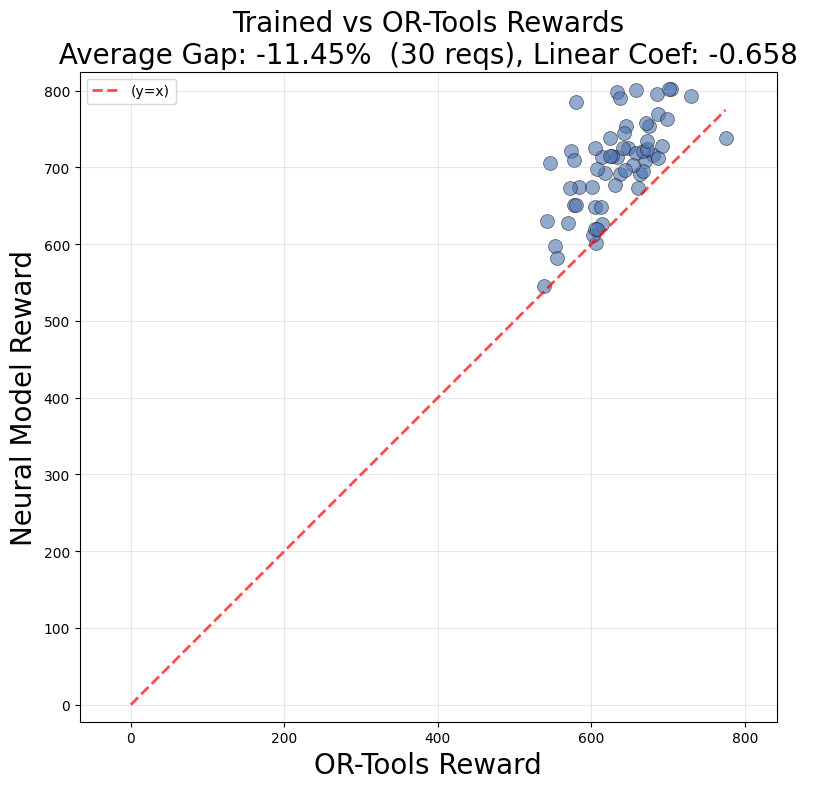

In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
reqs = 30

# Prepare data
trained_rewards = np.array(records[f"{reqs} req"]["neural"])
or_rewards = np.array(records[f"{reqs} req"]["or_tools"])


# ---- Filter out -inf values ----
mask = (trained_rewards != -np.inf) & (or_rewards != -np.inf)
trained_rewards = trained_rewards[mask]
or_rewards = or_rewards[mask]
# --------------------------------

# Create scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(
    or_rewards,
    -trained_rewards,
    alpha=0.6,
    s=100,
    color='#4c72b0',
    edgecolors='black',
    linewidth=0.5
)

# Add diagonal reference line
min_val = min(or_rewards.min(), trained_rewards.min())
max_val = max(or_rewards.max(), trained_rewards.max())
plt.plot(
    [0, max_val],
    [0, max_val],
    'r--',
    linewidth=2,
    label='(y=x)',
    alpha=0.7
)

# Labels and title
plt.xlabel("OR-Tools Reward", fontsize=20)
plt.ylabel("Neural Model Reward", fontsize=20)
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')

# Mean optimality gap (only for valid points)
gap = np.mean((or_rewards + trained_rewards) / np.abs(or_rewards)) * 100
slope, intercept, r_value, p_value, std_err = stats.linregress(or_rewards, trained_rewards)
plt.title(f"Trained vs OR-Tools Rewards\n Average Gap: {gap:.2f}%  ({reqs} reqs), Linear Coef: {r_value:.3f} ",fontsize=20)

plt.tight_layout()
plt.show()

In [226]:
def check_pairwise_validity(seq: torch.Tensor) -> bool:
    """
    Check if every subroute (separated by 0) contains only valid (2i-1, 2i) pairs.
    A pair is valid if for every request i, either both nodes (2i-1 and 2i)
    appear together in the same slice or neither appears at all.
    """
    # Convert tensor to list
    arr = seq.tolist()
    # Split by 0
    slices = []
    cur = []
    for x in arr:
        if x == 0:
            if cur:
                slices.append(cur)
                cur = []
        else:
            cur.append(x)
    if cur:
        slices.append(cur)

    # Check each slice
    for s in slices:
        s_set = set(s)
        for i in range(1, (max(s) // 2) + 2):
            a, b = 2 * i - 1, 2 * i
            in_a, in_b = a in s_set, b in s_set
            if in_a ^ in_b:  # only one of them is present
                return False
    return True

check_pairwise_validity(actions_trained[0])

False

/Users/jiangwolin/Desktop/Research/llm-rl/rl4co/rl4co/envs/routing/cvrptw/env.py:186: RuntimeWarning: vehicle cannot perform service and get back to depot in time.
  warnings.warn(
/Users/jiangwolin/Desktop/Research/llm-rl/rl4co/rl4co/envs/routing/cvrptw/env.py:215: RuntimeWarning: vehicle cannot start service before deadline
  warnings.warn(


FalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalse

/Users/jiangwolin/Desktop/Research/llm-rl/rl4co/rl4co/envs/routing/cvrp/env.py:191: RuntimeWarning: Used more than capacity
  warnings.warn("Used more than capacity", RuntimeWarning)


FalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalseFalse

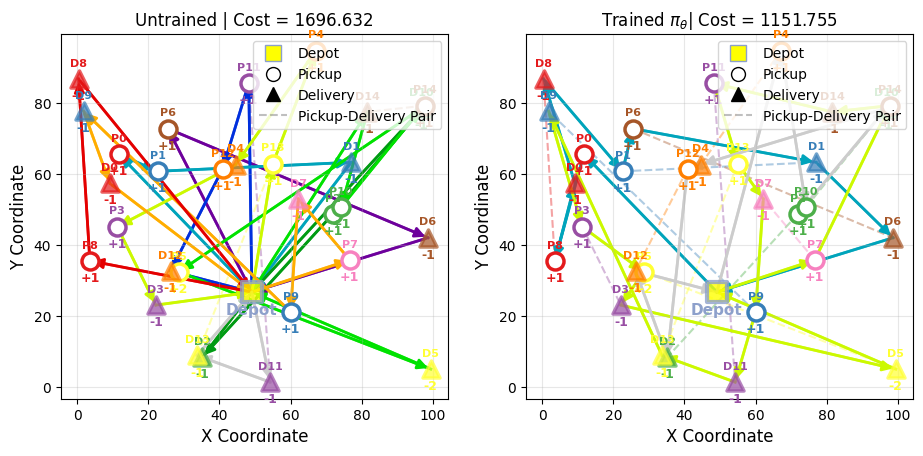

In [227]:
# Compare policy with untrained policy
check = False
while check == False: 
      
  # Testing: Greedy rollouts over trained model (same states as previous plot)
  env = PDPTWEnv(generator_params={"num_loc":30})
  td_init = env.reset(batch_size=[1]).to(device)

  out = policy(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
  actions_trained = out['actions'].cpu().detach()
  rewards_trained = out['reward']
  check = check_pairwise_validity(actions_trained[0])
  print(check, end='')
  

untrained_policy = AttentionModelPolicy(env_name=env.name, 
                              embed_dim=128,
                              num_encoder_layers=3,
                              num_heads=8
                            )

untrained_out = untrained_policy(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
actions_untrained = untrained_out['actions'].cpu().detach()
rewards_untrained = untrained_out['reward']



# Plotting
import matplotlib.pyplot as plt
for i, td in enumerate(td_init):
    fig, axs = plt.subplots(1,2, figsize=(11,5))
    env.render(td, actions_untrained[i], ax=axs[0]) 
    env.render(td, actions_trained[i], ax=axs[1])
    axs[0].set_title(f"Untrained | Cost = {-rewards_untrained[i].item():.3f}")
    axs[1].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-out['reward'][i].item():.3f}")

print(actions_trained)
